## Import libraries and define functions

In [5]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from cw_radar import *
from psg import *

def one_hot_encode(df_psg, df_xml, encode_type='stage'):
    """
    One-hot encode events or sleep stages and integrate into the PSG DataFrame.

    Parameters:
    - df_psg: DataFrame containing the PSG data.
    - df_xml: XMLProcessor object containing event and sleep stage data.
    - encode_type: str, either 'stage' or 'event' to specify what to encode.

    Returns:
    - DataFrame: PSG DataFrame with one-hot encoded columns integrated.
    """
    if encode_type == 'stage':
        df_data = df_xml.sleep_stages
        time_window = 30
        unique_items = df_data['Sleep Stage'].unique()
        time_column = 'Start Time'
    elif encode_type == 'event':
        df_data = df_xml.events
        time_window = 1
        unique_items = df_data['Name'].unique()
        time_column = 'Start'
    else:
        raise ValueError("Invalid encode_type. Must be 'stage' or 'event'.")

    # Create an empty DataFrame with the same index as df_psg
    one_hot_df = pd.DataFrame(index=df_psg.index)
    time_window = timedelta(seconds=time_window)
    
    # Create one-hot encoded columns for each unique item
    for item in unique_items:
        one_hot_df[item] = 0

    # Fill in the one-hot encoded values based on times
    for _, row in df_data.iterrows():
        start_time = row[time_column]
        
        if encode_type == 'stage':
            end_time = start_time + time_window
            item = row['Sleep Stage']
            mask = (df_psg.index >= start_time) & (df_psg.index < end_time)

        else:  # encode_type == 'event'
            end_time = row['End']
            item = row['Name']
            mask = (df_psg.index >= start_time - time_window) & (df_psg.index < end_time + time_window) # label window: 1s before and after the event
        
        one_hot_df.loc[mask, item] = 1

    return one_hot_df

def integrate(df_psg, df_xml):
    # One-hot encode events and sleep stages
    events_one_hot = one_hot_encode(df_psg, df_xml, encode_type='event')
    stages_one_hot = one_hot_encode(df_psg, df_xml, encode_type='stage')

    # Integrate the one-hot encoded DataFrames into the PSG DataFrame
    return pd.concat([df_psg, stages_one_hot, events_one_hot], axis=1)


## Load PSG data

In [2]:
file_path = "/Users/w.z/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/SleepData/苏州大学附属医院/PSG/2024-6-20jiangyifan.edf"
psg_processor = PSGDataProcessor(file_path)
psg_processor.load_data()

Extracting EDF parameters from /Users/w.z/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/SleepData/苏州大学附属医院/PSG/2024-6-20jiangyifan.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/w.z/Documents/GitHub/SleepLab/psg/psg_data_extraction.py:40: RuntimeWarning: Physical range is not defined in following channels:
Thor, Abdo, Sum
  self.data = mne.io.read_raw_edf(self.file_path, preload=False)


Sampling Rate: 1024.0
Channel Names: ['E1-M2', 'E2-M2', 'Chin 1-Chin 2', 'F4-M1', 'C4-M1', 'O2-M1', 'F3-M2', 'C3-M2', 'O1-M2', 'ECG', 'Pressure', 'Therm', 'Thor', 'Abdo', 'Sum', 'Mic', 'Position', 'SpO2', 'Ox Status', 'Leg/L', 'Leg/R', 'Pulse', 'Pleth']
Start Datetime: 2024-06-20 22:02:34


In [ ]:
print(len(psg_processor.data['ECG']))
print(psg_processor.data['ECG'][0]) # ECG data
print(len(psg_processor.data['ECG'][0][0]))
print(psg_processor.data['ECG'][1]) # ECG timestamps
print(len(psg_processor.data['ECG'][1]))

### Extract segments of ECG data

In [ ]:
# Specify the start and stop times in seconds
tmin, tmax = 10, 20  # Extract data between 10 and 20 seconds
psg_time_segment = psg_processor.extract_data_by_range(tmin, tmax)
print(psg_time_segment)

In [ ]:
# Extract data between two timestamps
start_datetime = datetime(2024, 6, 20, 22, 10, 33) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 20, 22, 11, 33)  # Replace with your actual end datetime
data_types = ['ECG', 'Pleth']  # Replace with your actual data types

print(f"Start Timestamp: {start_datetime}, End Timestamp: {end_datetime}")  # Print the start and end timestamps of the extracted data
psg_date_segment = psg_processor.extract_segment_by_timestamp(start_datetime, end_datetime, data_types)
print(psg_date_segment)


## Load XML data

In [3]:
file_path = 'psg/20240620江逸凡.edf.XML'
start_datetime_str = "2024-06-20 22:02:34"
xml_processor = XMLProcessor(file_path, start_datetime_str)

xml_processor.load()

                      Name  Actual Start (sec)  Duration  \
0              Mixed Apnea               91.67      0.24   
1     Limb Movement (Left)              336.65      2.15   
2    Limb Movement (Right)              336.61      2.24   
3     Limb Movement (Left)              499.71      2.27   
4    Limb Movement (Right)              500.37      1.69   
..                     ...                 ...       ...   
601            PLM (Right)            27023.70      2.02   
602  Limb Movement (Right)            27026.70      2.60   
603  Limb Movement (Right)            27099.80      2.15   
604  Limb Movement (Right)            27234.00      1.94   
605  Limb Movement (Right)            27337.50      1.69   

                      Start                     End    Input  
0   2024-06-20 22:04:05.670 2024-06-20 22:04:05.910  Airflow  
1   2024-06-20 22:08:10.650 2024-06-20 22:08:12.800    Leg/L  
2   2024-06-20 22:08:10.610 2024-06-20 22:08:12.850    Leg/R  
3   2024-06-20 22:10:53.710

In [ ]:
xml_processor.sleep_stages

In [ ]:
xml_processor.events

### Unique events and sleep stages

In [ ]:
unique_event_names = xml_processor.events['Name'].unique()
print(unique_event_names)

unique_sleep_stages = xml_processor.sleep_stages['Sleep Stage'].unique()
print(unique_sleep_stages)

### Filter by event type

In [ ]:
# Assuming xml_processor.df_events is your DataFrame
xml_filtered_by_type = xml_processor.events[xml_processor.events['Name'].str.contains('limb', case=False)]
xml_filtered_by_type

### Events filtered by time range

In [ ]:
# Filter rows where 'timestamp' is within the specified range
start_datetime = datetime(2024, 6, 20, 22, 10, 33) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 20, 22, 11, 33)  # Replace with your actual end datetime
xml_filtered_by_type = xml_filtered_by_type[(xml_filtered_by_type['Start'] >= start_datetime) & (xml_filtered_by_type['Start'] <= end_datetime)]
xml_filtered_by_type

In [ ]:
print(psg_date_segment)
print(xml_filtered_by_type)

### Events sorted by duration

In [ ]:
durations = xml_processor.events['Duration']
print(durations.describe())
xml_sorted_by_duration = xml_processor.events.sort_values(by='Duration', ascending=False)
print(xml_sorted_by_duration)

## Merge the two dataframes: PSG(bio signals) and XML(event labels)

### Load PSG and XML data

In [ ]:
psg_file_path = "/Users/w.z/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/SleepData/苏州大学附属医院/PSG/2024-6-20jiangyifan.edf"
psg_processor = PSGDataProcessor(psg_file_path)
psg_processor.load_data()

xml_file_path = 'psg/20240620江逸凡.edf.XML'
start_datetime_str = "2024-06-20 22:02:34"
xml_processor = XMLProcessor(xml_file_path, start_datetime_str)
xml_processor.load()

print(psg_processor.start_datetime)
print(xml_processor.start_datetime)

### Extract the time range of interest

In [ ]:
print(f"Start Timestamp: {psg_processor.start_datetime}, End Timestamp: {psg_processor.end_datetime}")

# Start Timestamp: 2024-06-20 22:02:34, End Timestamp: 2024-06-21 05:54:58.999023
start_datetime = datetime(2024, 6, 20, 22, 2, 34) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 21, 5, 54, 58)  # Replace with your actual end datetime
# # Extract data between two timestamps
# start_datetime = datetime(2024, 6, 20, 22, 10, 33) # Replace with your actual start datetime
# end_datetime = datetime(2024, 6, 20, 22, 11, 33)  # Replace with your actual end datetime
data_types = ['ECG', 'Pleth']  # Replace with your actual data types

print(f"Start Timestamp: {start_datetime}, End Timestamp: {end_datetime}")  # Print the start and end timestamps of the extracted data
psg_date_segment = psg_processor.extract_segment_by_timestamp(start_datetime, end_datetime, data_types)
print(psg_date_segment)

In [ ]:
# Specify the start and stop times in seconds
tmin, tmax = 0, 60  # Extract data between 10 and 20 seconds
data_types = ['ECG', 'Pleth']  # Replace with your actual data types

start_datetime, end_datetime, psg_time_segment = psg_processor.extract_data_by_range(tmin, tmax)
psg_time_segment = psg_time_segment[data_types]
print(f"Start time: {start_datetime}, End time: {end_datetime}")
print(psg_time_segment)

### Merge

In [ ]:
# Assuming df_psg is your processed PSG DataFrame
df_psg = psg_date_segment
# df_psg = psg_time_segment

# One-hot encode events and sleep stages
# events_one_hot_e = one_hot_encode(df_psg, xml_processor, 'event')
# events_one_hot_s = one_hot_encode(df_psg, xml_processor, 'stage')

merged_df = integrate(df_psg, xml_processor)
print(merged_df.head())

### Examine the correctness of the one-hot encoding

In [ ]:
s = xml_processor.sleep_stages
s_filtered = s[(s['Start Time'] >= start_datetime) & (s['Start Time'] <= end_datetime)]
print(s_filtered)

# Filter rows within the time range
merged_df = merged_df.loc[start_datetime:end_datetime]
# Define the list of columns to extract
t_filtered = merged_df[s_filtered['Sleep Stage']]
print(t_filtered)

# Extract the specified columns from filtered_temp
wake = t_filtered[t_filtered['Wakefulness (W)'] == 1]
print(wake.head().index[0])
stage1 = t_filtered[t_filtered['NREM Sleep Stage 1 (N1)'] == 1]
print(stage1.head().index[0])



### Save the complete(merged) DataFrame to a CSV/Pickle file

In [ ]:
# Define the file path and get the directory path and filename
# psg_file_path = "/Users/w.z/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/SleepData/苏州大学附属医院/PSG/2024-6-20jiangyifan.edf"
dir_path, filename = os.path.split(psg_file_path)
modified_filename = 'merged_' + filename

# # Save as CSV file for portability
# save_path = os.path.join(dir_path, modified_filename + '.csv')
# merged_df.to_csv(save_path, index=False)  # Set index=False if you don't want to save the index
# print(f"CSV file saved at: {save_path}")

# Save as Pickle file for efficiency and compactness
save_path = os.path.join(dir_path, modified_filename + '.pkl')
merged_df.to_pickle(save_path)
print(f"Pickle file saved at: {save_path}")

### Load the merged DataFrame

In [6]:
# Specify the path to the pickle file
save_path = "/Users/w.z/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/SleepData/苏州大学附属医院/PSG/merged_2024-6-20jiangyifan.edf.pkl"
pickle_path = save_path # '/path/to/your/filename.pkl'
df = pd.read_pickle(pickle_path)

# Display the first few rows of the DataFrame
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: '/Users/w.z/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/SleepData/苏州大学附属医院/PSG/merged_2024-6-20jiangyifan.edf.pkl'

## ERA(Event-related Analysis): Sleep Stages

### The Dataset

In [5]:
df_sleep_stages = xml_processor.sleep_stages
df_sleep_stages


,Time (seconds),Start Time,Sleep Stage Code,Sleep Stage
0,0,2024-06-20 22:02:34,9,Movement Time (MT)
1,30,2024-06-20 22:03:04,9,Movement Time (MT)
2,60,2024-06-20 22:03:34,9,Movement Time (MT)
3,90,2024-06-20 22:04:04,9,Movement Time (MT)
4,120,2024-06-20 22:04:34,9,Movement Time (MT)
...,...,...,...,...
939,28170,2024-06-21 05:52:04,0,Wakefulness (W)
940,28200,2024-06-21 05:52:34,0,Wakefulness (W)
941,28230,2024-06-21 05:53:04,0,Wakefulness (W)
942,28260,2024-06-21 05:53:34,0,Wakefulness (W)


In [6]:
codes = xml_processor.sleep_stages['Sleep Stage Code'].values
print(np.unique(codes))

stages = xml_processor.sleep_stages['Sleep Stage'].values
print(np.unique(stages))

[0 1 2 3 5 9]
['Movement Time (MT)' 'NREM Sleep Stage 1 (N1)' 'NREM Sleep Stage 2 (N2)'
 'NREM Sleep Stage 3 (N3)' 'REM Sleep' 'Wakefulness (W)']


#### Prepare the data (Time window)

In [35]:
# start_datetime = datetime(2024, 6, 20, 22, 40, 33) # Replace with your actual start datetime
# end_datetime = datetime(2024, 6, 20, 23, 10, 33)  # Replace with your actual end datetime
start_datetime = datetime(2024, 6, 20, 22, 40, 33) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 20, 23, 00, 33)  # Replace with your actual end datetime

start_time = start_datetime
end_time = end_datetime

filtered_df = df.loc[start_time:end_time]
df_subset = filtered_df[['ECG', 'Pleth']]
print(df_subset.head())

                                     ECG    Pleth
Time                                             
2024-06-20 22:40:33.000000 -2.994583e-06 -0.00325
2024-06-20 22:40:33.000977 -1.888304e-06 -0.00322
2024-06-20 22:40:33.001953  1.716640e-07 -0.00322
2024-06-20 22:40:33.002930  1.773861e-06 -0.00322
2024-06-20 22:40:33.003906  1.697566e-06 -0.00322


#### Prepare the data (add columns)

In [37]:
def add_sleep_stage_column(df_subset, df_sleep_stages):
    # Create a new column in df_subset to store the sleep stage code
    df_subset['Stage Code'] = None

    # Iterate over each row in df_sleep_stages
    for index, row in df_sleep_stages.iterrows():
        stage_start_time = row['Start Time']
        stage_end_time = stage_start_time + timedelta(seconds=30)

        # Find the rows in df_subset that fall within the current sleep stage interval
        mask = (df_subset.index >= stage_start_time) & (df_subset.index < stage_end_time)
        
        # Assign the sleep stage code to the corresponding rows in df_subset
        df_subset.loc[mask, 'Stage Code'] = row['Sleep Stage Code']
        # df_subset.loc[mask, 'Sleep Stage'] = row['Sleep Stage']
        # df_subset.loc[mask, 'Time (seconds)'] = row['Time (seconds)']
        # df_subset.loc[mask, 'Duration'] = row['Duration']
    
    return df_subset

# Example usage
# Apply the function to add the sleep stage column
df_subset_with_sleep_stage = add_sleep_stage_column(df_subset, df_sleep_stages)

print(df_subset_with_sleep_stage)
print(df_subset_with_sleep_stage['Stage Code'].value_counts())

/var/folders/l8/5lgpkmx16ksc0grqcv9pb52c0000gn/T/ipykernel_86406/2135906033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Stage Code'] = None


                                     ECG     Pleth Stage Code
Time                                                         
2024-06-20 22:40:33.000000 -2.994583e-06 -0.003250          3
2024-06-20 22:40:33.000977 -1.888304e-06 -0.003220          3
2024-06-20 22:40:33.001953  1.716640e-07 -0.003220          3
2024-06-20 22:40:33.002930  1.773861e-06 -0.003220          3
2024-06-20 22:40:33.003906  1.697566e-06 -0.003220          3
...                                  ...       ...        ...
2024-06-20 23:00:32.996094  1.230831e-04  0.000900          1
2024-06-20 23:00:32.997070  1.271267e-04  0.000900          1
2024-06-20 23:00:32.998047  1.294919e-04  0.000931          1
2024-06-20 23:00:32.999023  1.301022e-04  0.000961          1
2024-06-20 23:00:33.000000  1.292630e-04  0.000992          1

[1228801 rows x 3 columns]
Stage Code
3    1137664
0      61440
1      29697
Name: count, dtype: int64


In [10]:
# psg_processor.signals_diagram(df_subset_with_sleep_stage)

### Find Events (Auto)

#### Process and plot the events

{'onset': array([1137664]), 'duration': array([61440]), 'label': array(['1'], dtype='<U21')}


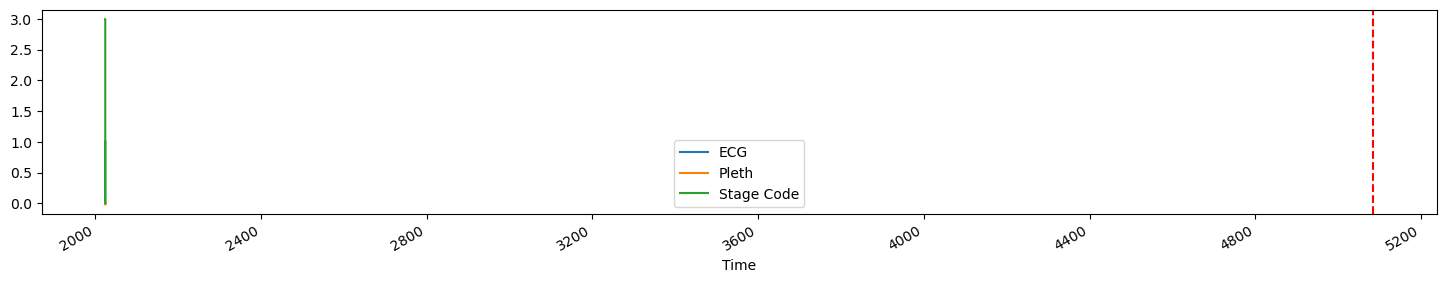

In [94]:
# Define events based on sleep stages
# df_subset_with_sleep_stage['ECG'] = df_subset_with_sleep_stage['ECG'] *100000
# df_subset_with_sleep_stage['Pleth'] = df_subset_with_sleep_stage['Pleth'] *100000
events1 = nk.events_find(df_subset_with_sleep_stage['Stage Code'], threshold=0, threshold_keep='below')
print(events1)
plot = nk.events_plot(events1, df_subset_with_sleep_stage)


{'onset': array([      0, 1199104]), 'duration': array([1137664,   29697]), 'label': array(['1', '2'], dtype='<U21')}


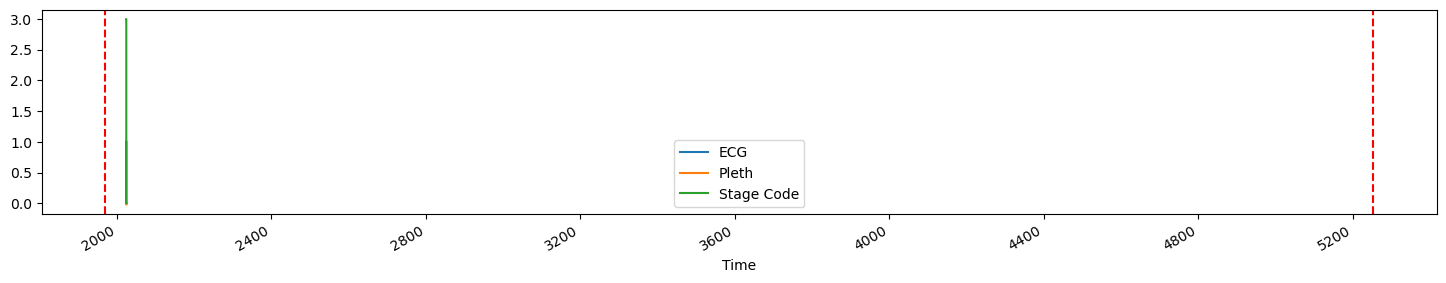

In [95]:
events2 = nk.events_find(df_subset_with_sleep_stage['Stage Code'], threshold=0, threshold_keep='above')
print(events2)
plot = nk.events_plot(events2, df_subset_with_sleep_stage)


In [40]:
print(events1)
print(events2)

{'onset': array([1137664]), 'duration': array([61440]), 'label': array(['1'], dtype='<U21')}
{'onset': array([      0, 1199104]), 'duration': array([1137664,   29697]), 'label': array(['1', '2'], dtype='<U21')}


In [41]:

# Combine the arrays
combined_onset = np.concatenate((events1['onset'], events2['onset']))
combined_duration = np.concatenate((events1['duration'], events2['duration']))

# Sort the arrays based on the combined onset values
sorted_indices = np.argsort(combined_onset)
sorted_onset = combined_onset[sorted_indices]
sorted_duration = combined_duration[sorted_indices]
sorted_label = [str(i+1) for i in range(len(sorted_onset))]


# Create the merged dictionary
merged_events = {
    'onset': sorted_onset,
    'duration': sorted_duration,
    'label': sorted_label
}

print(merged_events)


{'onset': array([      0, 1137664, 1199104]), 'duration': array([1137664,   61440,   29697]), 'label': ['1', '2', '3']}


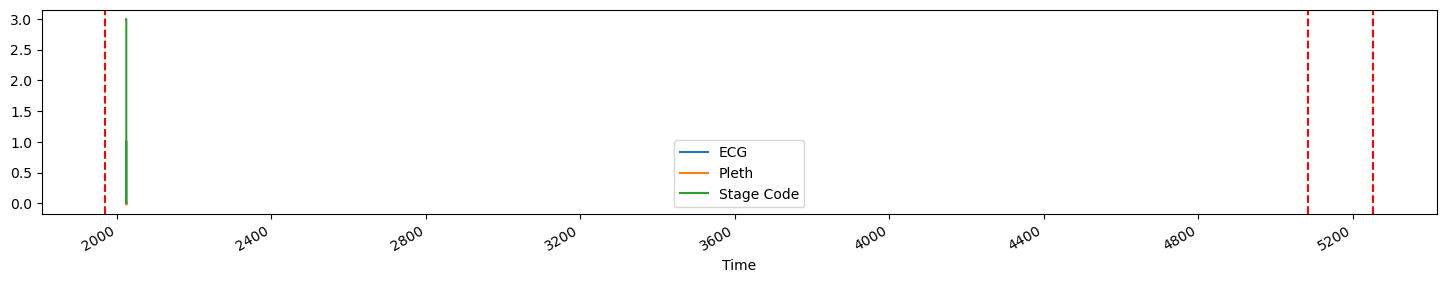

In [42]:
plot = nk.events_plot(merged_events, df_subset_with_sleep_stage)

#### Plot RSP diagram (trial)

In [16]:
psg_processor.start_datetime

datetime.datetime(2024, 6, 20, 22, 2, 34)

61440
2024-06-20 22:02:34
The raw signal, sampled at 1024.0 Hz, was preprocessed using a second order 0.05-3 Hz bandpass Butterworth filter.

The peak detection was carried out using the method described in Khoadadad et al. (2018).

The respiratory volume per time computation was carried out using the method described in Harrison et al. (2021).

|   RSP_Rate_Mean |   RSP_Rate_SD |
|----------------:|--------------:|
|         55.6309 |       16.2605 |

References
- Harrison, S. J., Bianchi, S., Heinzle, J., Stephan, K. E., Iglesias, S., & Kasper, L. (2021).
            A Hilbert-based method for processing respiratory timeseries.
            Neuroimage, 230, 117787.
- Khodadad, D., Nordebo, S., Müller, B., Waldmann, A., Yerworth, R., Becher, T., ... & Bayford, R. (2018).
            Optimized breath detection algorithm in electrical impedance tomography.
            Physiological measurement, 39(9), 094001.
- Makowski, D., Pham, T., Lau, Z. J., Brammer, J. C., Lespinasse, F., Pham, H.,

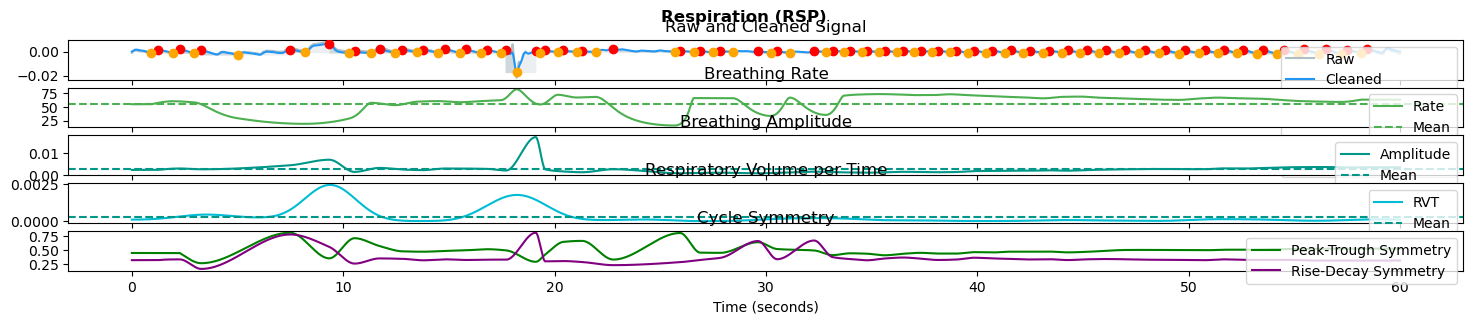

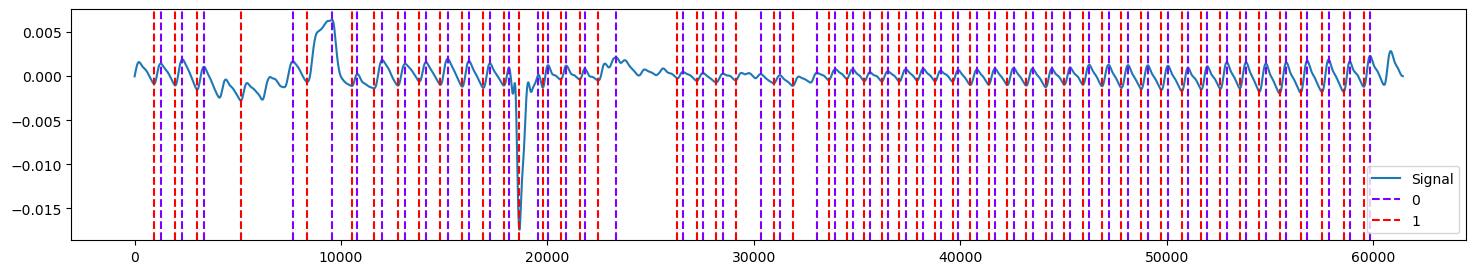

In [17]:
extracted_types = ['Pleth']
start_datetime = datetime(2024, 6, 20, 22, 58, 33) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 20, 22, 59, 33)  # Replace with your actual end datetime
extracted_data = psg_processor.extract_segment_by_timestamp(start_datetime, end_datetime, extracted_types)
rsp_signals, rsp_info = psg_processor.rsp_diagram(extracted_data['Pleth'])


#### Process the Signals

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

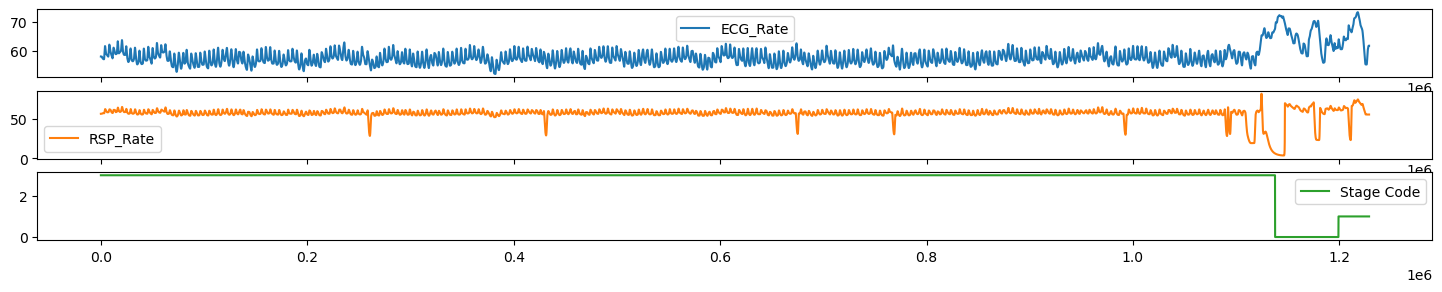

In [43]:
# Process the signal
data_clean, info = nk.bio_process(ecg=df_subset_with_sleep_stage["ECG"], 
                                  rsp=df_subset_with_sleep_stage["Pleth"],
                                  keep=df_subset_with_sleep_stage["Stage Code"],  
                                  sampling_rate=1024)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", "Stage Code"]].plot(subplots=True)

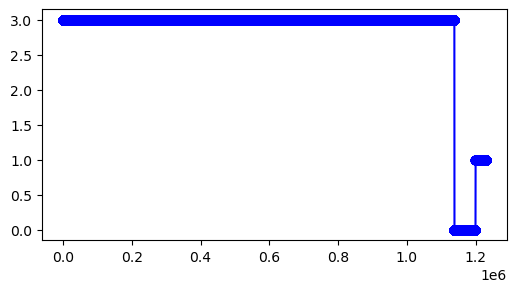

In [44]:
x = df_subset_with_sleep_stage['Stage Code'].values

plt.figure(figsize=(6, 3))  # Set the figure size for better readability
plt.plot(x, marker='o', linestyle='-', color='b')  # Plot x with markers and lines
plt.show()  

#### Create Epochs

In [45]:
# Build and plot epochs
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=-30, epochs_end=30)

/Users/w.z/opt/anaconda3/envs/fall/lib/python3.9/site-packages/neurokit2/epochs/epochs_create.py:172: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  buffer.select_dtypes(exclude="int64").replace({0.0: np.nan}, inplace=True)


In [46]:
for epoch_index, epoch in epochs.items():
    for attribute, value in epoch.items():
        print(f"  {attribute}")
    print("\n")  # Adds a newline for better readability between epochs

  ECG_Raw
  ECG_Clean
  ECG_Rate
  ECG_Quality
  ECG_R_Peaks
  ECG_P_Peaks
  ECG_P_Onsets
  ECG_P_Offsets
  ECG_Q_Peaks
  ECG_R_Onsets
  ECG_R_Offsets
  ECG_S_Peaks
  ECG_T_Peaks
  ECG_T_Onsets
  ECG_T_Offsets
  ECG_Phase_Atrial
  ECG_Phase_Completion_Atrial
  ECG_Phase_Ventricular
  ECG_Phase_Completion_Ventricular
  RSP_Raw
  RSP_Clean
  RSP_Amplitude
  RSP_Rate
  RSP_RVT
  RSP_Phase
  RSP_Phase_Completion
  RSP_Symmetry_PeakTrough
  RSP_Symmetry_RiseDecay
  RSP_Peaks
  RSP_Troughs
  Stage Code
  RSA_P2T
  RSA_Gates
  Index
  Label


  ECG_Raw
  ECG_Clean
  ECG_Rate
  ECG_Quality
  ECG_R_Peaks
  ECG_P_Peaks
  ECG_P_Onsets
  ECG_P_Offsets
  ECG_Q_Peaks
  ECG_R_Onsets
  ECG_R_Offsets
  ECG_S_Peaks
  ECG_T_Peaks
  ECG_T_Onsets
  ECG_T_Offsets
  ECG_Phase_Atrial
  ECG_Phase_Completion_Atrial
  ECG_Phase_Ventricular
  ECG_Phase_Completion_Ventricular
  RSP_Raw
  RSP_Clean
  RSP_Amplitude
  RSP_Rate
  RSP_RVT
  RSP_Phase
  RSP_Phase_Completion
  RSP_Symmetry_PeakTrough
  RSP_Symmetry_RiseD

In [47]:
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals
    print(epoch['Label'])

-30.000000    1
-29.999023    1
-29.998047    1
-29.997070    1
-29.996094    1
             ..
 29.996094    1
 29.997070    1
 29.998047    1
 29.999023    1
 30.000000    1
Name: Label, Length: 61440, dtype: string
-30.000000    2
-29.999023    2
-29.998047    2
-29.997070    2
-29.996094    2
             ..
 29.996094    2
 29.997070    2
 29.998047    2
 29.999023    2
 30.000000    2
Name: Label, Length: 61440, dtype: string
-30.000000    3
-29.999023    3
-29.998047    3
-29.997070    3
-29.996094    3
             ..
 29.996094    3
 29.997070    3
 29.998047    3
 29.999023    3
 30.000000    3
Name: Label, Length: 61440, dtype: string


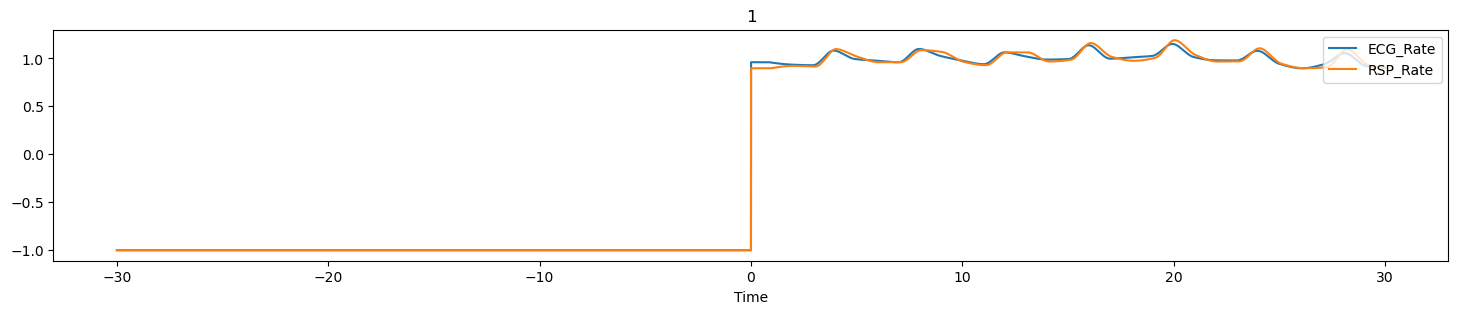

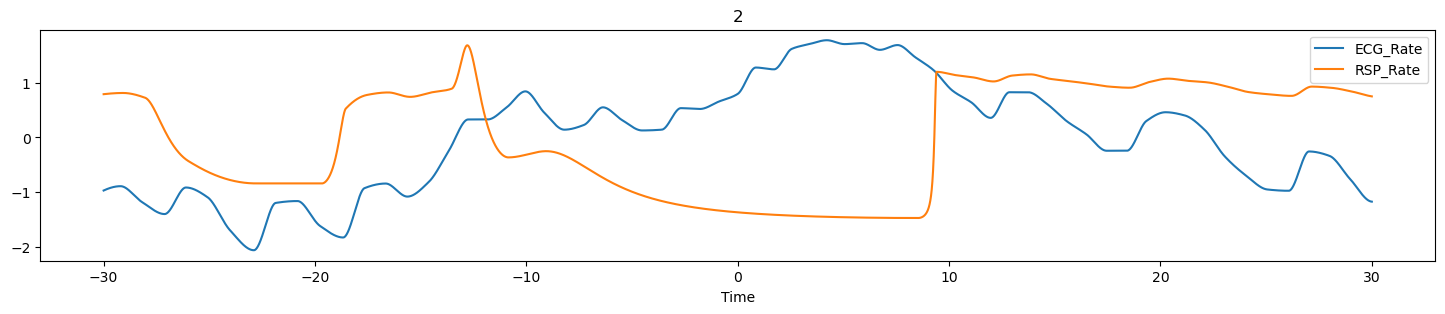

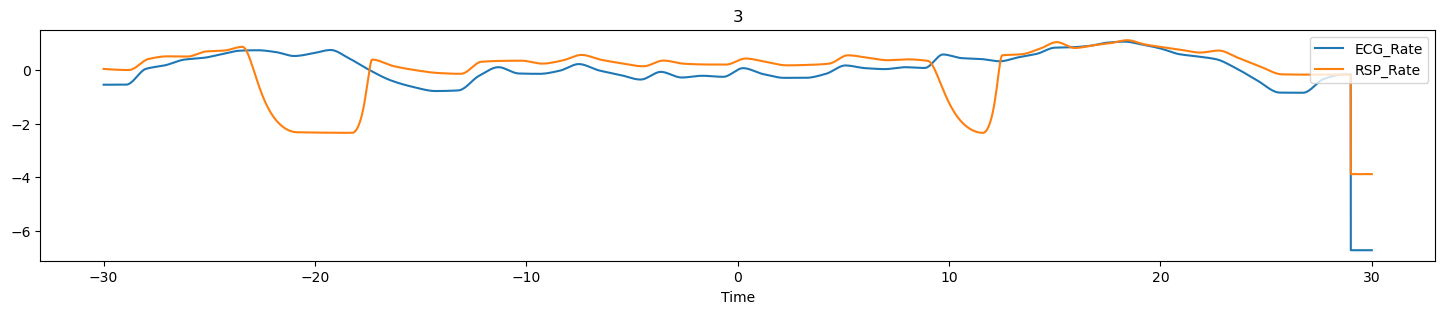

In [48]:
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals, "Stage Code"
    nk.signal_plot(epoch[['ECG_Rate', 'RSP_Rate']], 
                   title=epoch['Label'].values[0],  # Extract condition name
                   standardize=True)  

#### Interval Analysis

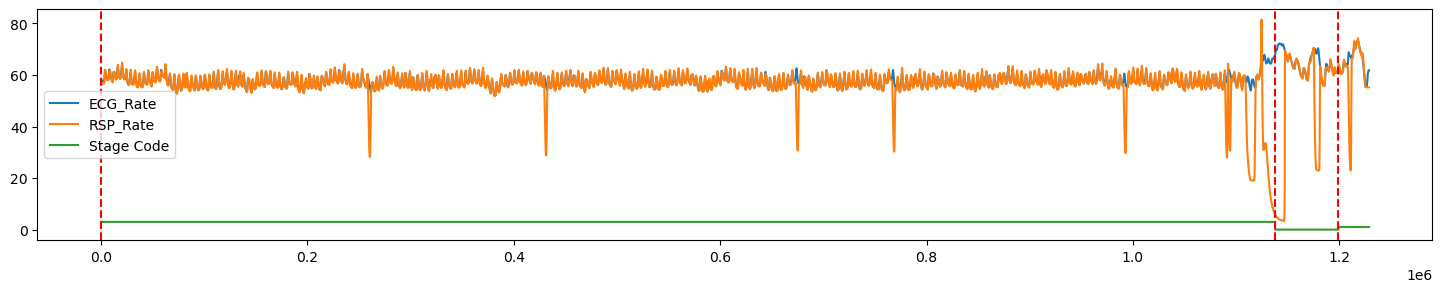

In [49]:
plot = nk.events_plot(merged_events,data_clean[["ECG_Rate", "RSP_Rate", "Stage Code"]])

In [50]:
print(merged_events)
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=0, epochs_end='from_events')

{'onset': array([      0, 1137664, 1199104]), 'duration': array([1137664,   61440,   29697]), 'label': ['1', '2', '3']}


/Users/w.z/opt/anaconda3/envs/fall/lib/python3.9/site-packages/neurokit2/epochs/epochs_create.py:172: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  buffer.select_dtypes(exclude="int64").replace({0.0: np.nan}, inplace=True)


In [51]:
# Analyze
nk.ecg_intervalrelated(epochs)

/Users/w.z/opt/anaconda3/envs/fall/lib/python3.9/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/Users/w.z/opt/anaconda3/envs/fall/lib/python3.9/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


,Label,ECG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
1,1,57.571403,[[1067.4206572769954]],[[42.40519662370877]],[[12.66768210037112]],[[40.30414206951187]],[[4.6150545676624946]],[[39.39045679259046]],[[8.134949799179125]],[[41.861406029525575]],...,[[1.2447414795458667]],[[7.166744607711821]],[[1.2371360392697177]],[[0.7080356842055872]],[[1.3875128307217204]],[[2.006997298327986]],[[1.616371093838919]],[[2.0009476132811703]],[[5.281656536503186]],[[0.6609996620262197]]
2,2,64.766173,[[950.1587301587301]],[[65.56090651354376]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[0.8979415932059585]],[[5.755057701277694]],[[0.8228688703952347]],[[0.0]],[[0.9452938266945459]],[[1.0370399735795708]],[[1.6696585383137683]],[[1.454497088375607]],[[1.81987118584451]],[[0.7590196728253863]]
3,3,65.355820,[[940.0]],[[72.62276961578006]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],[[nan]],...,[[1.0414538748281612]],[[4.825164052322359]],[[0.8306259019899264]],[[0.0]],[[0.0]],[[0.0]],[[1.7159711171504053]],[[1.3697284390374722]],[[1.7894345866184995]],[[0.6392511368241129]]


In [52]:
nk.rsp_intervalrelated(epochs)

,Label,RSP_Rate_Mean,RRV_RMSSD,RRV_MeanBB,RRV_SDBB,RRV_SDSD,RRV_CVBB,RRV_CVSD,RRV_MedianBB,RRV_MadBB,...,RAV_Mean,RAV_SD,RAV_RMSSD,RAV_CVSD,RSP_RVT,RSP_Symmetry_PeakTrough,RSP_Symmetry_RiseDecay,RSP_Phase_Duration_Inspiration,RSP_Phase_Duration_Expiration,RSP_Phase_Duration_Ratio
1,1,56.502276,162.206092,1083.022094,143.063563,162.282541,0.132097,0.149772,1079.0,50.4084,...,0.005073,0.001292,0.000946,0.186478,0.000360,0.577361,0.289824,0.000309,0.000747,0.414099
2,2,50.753076,354.278197,1042.360000,338.465792,357.939993,0.324711,0.339881,977.0,55.5975,...,0.002631,0.000722,0.000216,0.082273,0.000120,0.553206,0.313313,0.000319,0.000697,0.457408
3,3,61.458387,480.678367,1004.407407,343.955974,490.172761,0.342447,0.478569,932.0,81.5430,...,0.003115,0.000702,0.000385,0.123474,0.000159,0.523733,0.344764,0.000355,0.000622,0.570909


#### Plot ECG and RSP signals

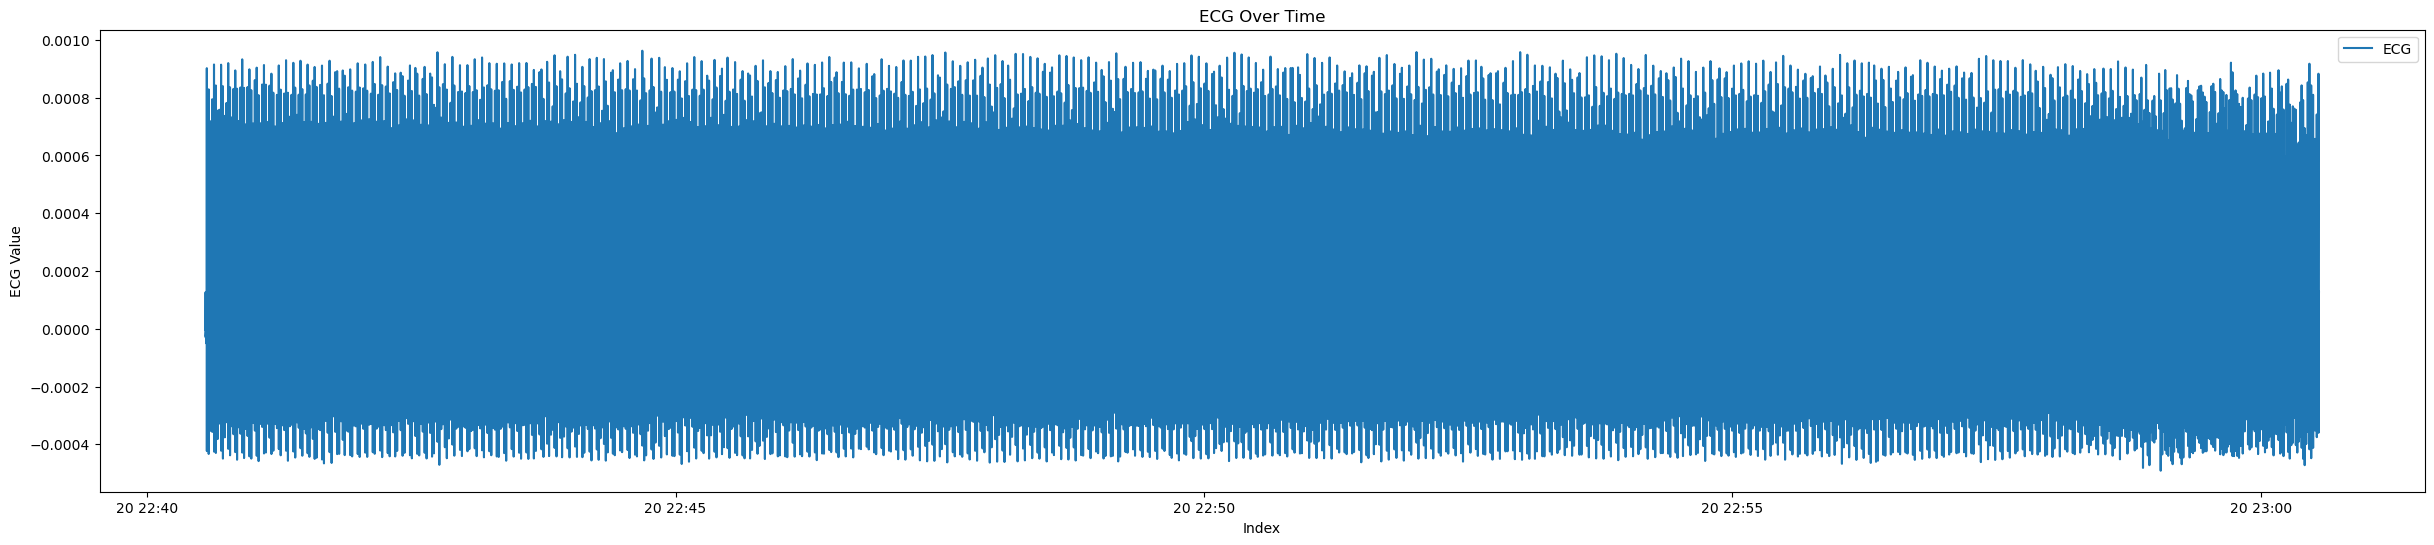

In [55]:
plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset['ECG'], label='ECG')  # Plot the ECG column
plt.title('ECG Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('ECG Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

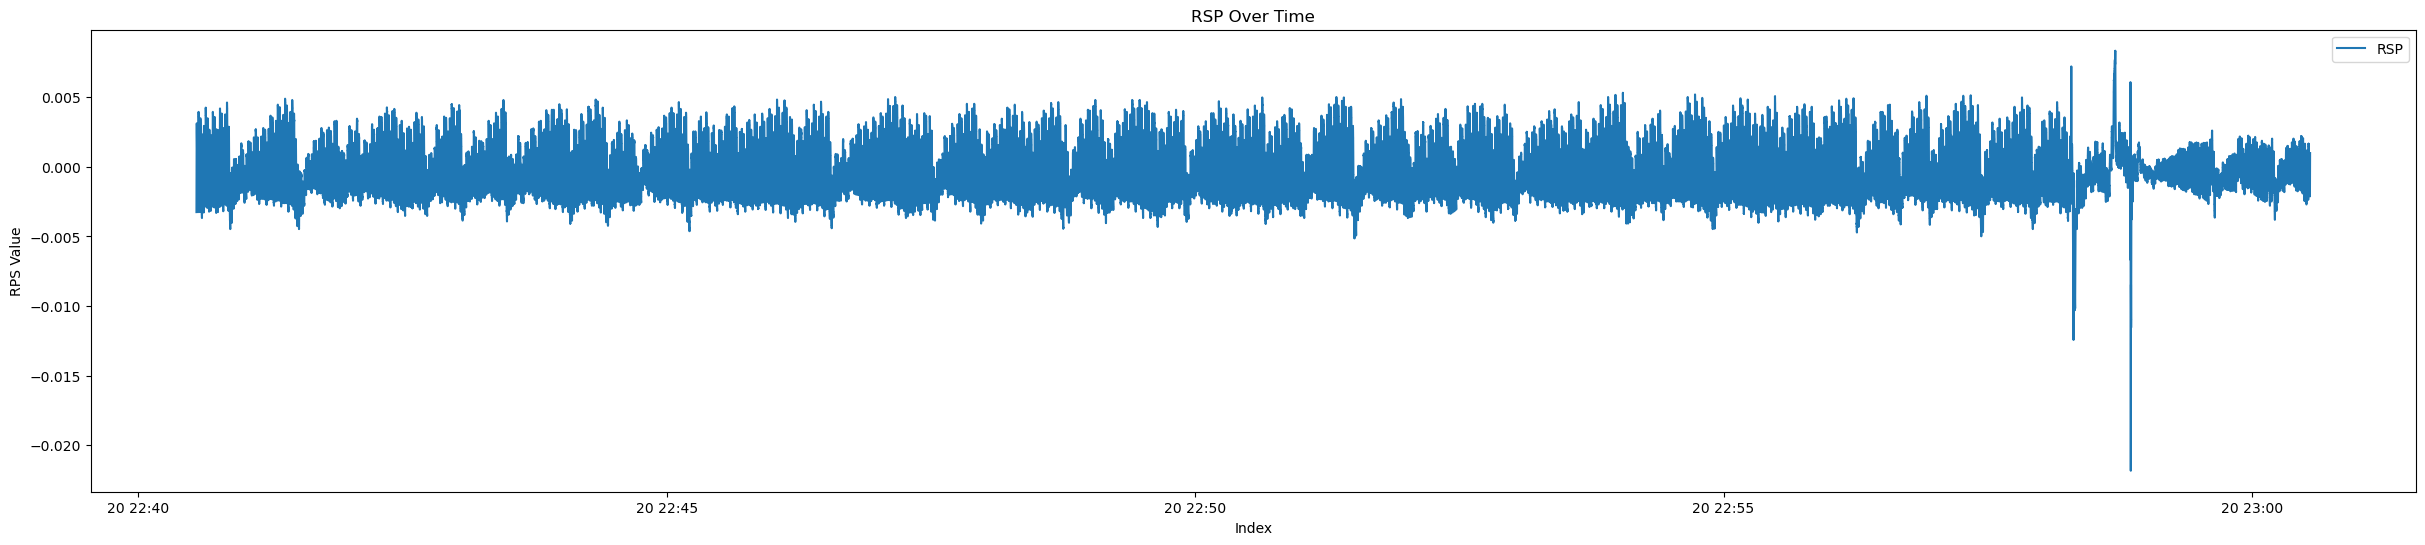

In [56]:
plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset['Pleth'], label='RSP')  # Plot the ECG column
plt.title('RSP Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('RPS Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

#### Feature Extraction (Auto)

In [ ]:
# df = nk.bio_analyze(epochs, sampling_rate=1024)
# df

#### Feature Extraction (Manual)

In [ ]:
df = {}  # Initialize an empty dict to store the results
         
# Iterate through epochs index and data
for epoch_index, epoch in epochs.items():
    df[epoch_index] = {}  # Initialize an empty dict inside of it
                            

    # Note: We will use the 100th value (corresponding to the event onset, 0s) as the baseline

    # ECG ====
    ecg_baseline = epoch["ECG_Rate"].values[100]  # Baseline
    ecg_mean = epoch["ECG_Rate"][0:4].mean()  # Mean heart rate in the 0-4 seconds
    # Store ECG in df
    df[epoch_index]["ECG_Rate_Mean"] = ecg_mean - ecg_baseline  # Correct for baseline

    # RSP ====
    rsp_baseline = epoch["RSP_Rate"].values[100]  # Baseline
    rsp_rate = epoch["RSP_Rate"][0:6].mean()  # Longer window for RSP that has a slower dynamic
    # Store RSP in df
    df[epoch_index]["RSP_Rate_Mean"] = rsp_rate - rsp_baseline  # Correct for baseline

df = pd.DataFrame.from_dict(df, orient="index")  # Convert to a dataframe
df  # Print DataFrame

#### Plot Event-Related Features

In [ ]:
df_reset = df.reset_index()
print(df_reset)

In [ ]:
import seaborn as sns
sns.boxplot(x="index", y="ECG_Rate_Mean", data=df_reset)

In [ ]:
import seaborn as sns
sns.boxplot(x="index", y="RSP_Rate_Mean", data=df_reset)

### Find Events (Manual)

In [ ]:
df_sleep_stages['Duration'] = 30
df_sleep_stages

#### Prepare the data (add columns)

In [ ]:
def add_sleep_stage_column(df_subset, df_sleep_stages):
    # Create a new column in df_subset to store the sleep stage code
    df_subset['Stage Code'] = None

    # Iterate over each row in df_sleep_stages
    for index, row in df_sleep_stages.iterrows():
        stage_start_time = row['Start Time']
        stage_end_time = stage_start_time + timedelta(seconds=30)

        # Find the rows in df_subset that fall within the current sleep stage interval
        mask = (df_subset.index >= stage_start_time) & (df_subset.index < stage_end_time)
        
        # Assign the sleep stage code to the corresponding rows in df_subset
        df_subset.loc[mask, 'Stage Code'] = row['Sleep Stage Code']
        df_subset.loc[mask, 'Sleep Stage'] = row['Sleep Stage']
        df_subset.loc[mask, 'Time (seconds)'] = row['Time (seconds)']
        df_subset.loc[mask, 'Duration'] = row['Duration']
    
    return df_subset

# Example usage
# Apply the function to add the sleep stage column
df_subset_sleep = add_sleep_stage_column(df_subset, df_sleep_stages)

print(df_subset_sleep)
print(df_subset_sleep['Stage Code'].value_counts())

#### Create Events

In [ ]:
def extract_sleep_stages(df_sleep_stages, start_datetime, end_datetime):
    
    # Calculate 'End Time' assuming each stage lasts 30 seconds
    df_sleep_stages['End Time'] = df_sleep_stages['Start Time'] + pd.Timedelta(seconds=30)
    df_subset = df_sleep_stages[(df_sleep_stages['Start Time'] >= start_datetime) & (df_sleep_stages['End Time'] <= end_datetime)]
    
    return df_subset



In [ ]:
start_datetime = datetime(2024, 6, 20, 22, 40, 33) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 20, 23, 10, 33)  # Replace with your actual end datetime

df_subset_sleep = extract_sleep_stages(df_sleep_stages, start_datetime, end_datetime)
df_subset_sleep.head()

In [ ]:
df_sleep_stages_dur = df_subset_sleep
event_onsets = df_sleep_stages_dur['Time (seconds)'].values
event_durations = df_sleep_stages_dur['Duration'].values
event_conditions = df_sleep_stages_dur['Sleep Stage'].values

events = nk.events_create(event_onsets = event_onsets,
                          event_durations = event_durations,
                          event_conditions= event_conditions)

print(events)


In [ ]:
print(df_subset)
print(df_subset_sleep['Sleep Stage Code'].value_counts())

#### Plot the events

In [ ]:
events

In [ ]:

# Plot the location of event with the signals
plot = nk.events_plot(events, df_subset)

## IRA(Interval-related Analysis)

In [ ]:
# Process the signal
data_clean, info = nk.bio_process(ecg=df_subset_with_sleep_stage["ECG"], 
                                  rsp=df_subset_with_sleep_stage["Pleth"],
                                  keep=df_subset_with_sleep_stage["Stage Code"],  
                                  sampling_rate=1024)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", "Stage Code"]].plot(subplots=True)

In [ ]:
df, info = nk.ecg_process(df_subset_with_sleep_stage["ECG"], sampling_rate=1024)
nk.ecg_intervalrelated(df, sampling_rate=1024)


In [ ]:
epochs = nk.epochs_create(df, events=[0, 15000], sampling_rate=100, epochs_end=150)

# Half the data
epochs = nk.epochs_create(ecg_signals, 
                          events=[0, 15000], 
                          sampling_rate=100, 
                          epochs_start=0, 
                          epochs_end=150)

nk.ecg_intervalrelated(epochs)

## ERA(Event-related Analysis): Events

## Limb Movement

In [ ]:
event_type = 'Limb Movement (Left)'

### The Dataset

In [58]:
df_sleep_events = xml_processor.events
df_sleep_events


,Name,Actual Start (sec),Duration,Start,End,Input
0,Mixed Apnea,91.67,0.24,2024-06-20 22:04:05.670,2024-06-20 22:04:05.910,Airflow
1,Limb Movement (Left),336.65,2.15,2024-06-20 22:08:10.650,2024-06-20 22:08:12.800,Leg/L
2,Limb Movement (Right),336.61,2.24,2024-06-20 22:08:10.610,2024-06-20 22:08:12.850,Leg/R
3,Limb Movement (Left),499.71,2.27,2024-06-20 22:10:53.710,2024-06-20 22:10:55.980,Leg/L
4,Limb Movement (Right),500.37,1.69,2024-06-20 22:10:54.370,2024-06-20 22:10:56.060,Leg/R
...,...,...,...,...,...,...
601,PLM (Right),27023.70,2.02,2024-06-21 05:32:57.700,2024-06-21 05:32:59.720,Leg/R
602,Limb Movement (Right),27026.70,2.60,2024-06-21 05:33:00.700,2024-06-21 05:33:03.300,Leg/R
603,Limb Movement (Right),27099.80,2.15,2024-06-21 05:34:13.800,2024-06-21 05:34:15.950,Leg/R
604,Limb Movement (Right),27234.00,1.94,2024-06-21 05:36:28.000,2024-06-21 05:36:29.940,Leg/R


In [59]:
events = xml_processor.events['Name'].values
print(np.unique(events))


['Arousal (ARO Limb)' 'Arousal (ARO PLM)' 'Arousal (ARO RES)'
 'Arousal (ARO SPONT)' 'Central Apnea' 'Hypopnea' 'Limb Movement (Left)'
 'Limb Movement (Right)' 'Mixed Apnea' 'Obstructive Apnea' 'PLM (Left)'
 'PLM (Right)' 'SpO2 artifact' 'SpO2 desaturation']


#### Prepare the data (Time window)

In [86]:
# start_datetime = datetime(2024, 6, 20, 22, 40, 33) # Replace with your actual start datetime
# end_datetime = datetime(2024, 6, 20, 23, 10, 33)  # Replace with your actual end datetime
start_datetime = datetime(2024, 6, 20, 22, 8, 0) # 2024-06-20 22:08:00
end_datetime = datetime(2024, 6, 20, 22, 11, 0) # 2024-06-20 22:11:00

start_time = start_datetime
end_time = end_datetime

filtered_df = df.loc[start_time:end_time]
# Make a df subset with all the columns except: 
# 'ECG', 'Pleth', 'Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 
# 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)'
columns_to_drop = ['Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)']
df_subset = filtered_df.drop(columns=columns_to_drop)
print(df_subset.head())

                                 ECG     Pleth  Mixed Apnea  \
Time                                                          
2024-06-20 22:08:00.000000  0.000017 -0.001816            0   
2024-06-20 22:08:00.000977  0.000015 -0.001846            0   
2024-06-20 22:08:00.001953  0.000013 -0.001846            0   
2024-06-20 22:08:00.002930  0.000011 -0.001846            0   
2024-06-20 22:08:00.003906  0.000009 -0.001846            0   

                            Limb Movement (Left)  Limb Movement (Right)  \
Time                                                                      
2024-06-20 22:08:00.000000                     0                      0   
2024-06-20 22:08:00.000977                     0                      0   
2024-06-20 22:08:00.001953                     0                      0   
2024-06-20 22:08:00.002930                     0                      0   
2024-06-20 22:08:00.003906                     0                      0   

                            SpO2

In [87]:
df_sleep_events

,Name,Actual Start (sec),Duration,Start,End,Input
0,Mixed Apnea,91.67,0.24,2024-06-20 22:04:05.670,2024-06-20 22:04:05.910,Airflow
1,Limb Movement (Left),336.65,2.15,2024-06-20 22:08:10.650,2024-06-20 22:08:12.800,Leg/L
2,Limb Movement (Right),336.61,2.24,2024-06-20 22:08:10.610,2024-06-20 22:08:12.850,Leg/R
3,Limb Movement (Left),499.71,2.27,2024-06-20 22:10:53.710,2024-06-20 22:10:55.980,Leg/L
4,Limb Movement (Right),500.37,1.69,2024-06-20 22:10:54.370,2024-06-20 22:10:56.060,Leg/R
...,...,...,...,...,...,...
601,PLM (Right),27023.70,2.02,2024-06-21 05:32:57.700,2024-06-21 05:32:59.720,Leg/R
602,Limb Movement (Right),27026.70,2.60,2024-06-21 05:33:00.700,2024-06-21 05:33:03.300,Leg/R
603,Limb Movement (Right),27099.80,2.15,2024-06-21 05:34:13.800,2024-06-21 05:34:15.950,Leg/R
604,Limb Movement (Right),27234.00,1.94,2024-06-21 05:36:28.000,2024-06-21 05:36:29.940,Leg/R


#### Prepare the data (add columns)

In [ ]:
def add_sleep_stage_column(df_subset, df_sleep_stages):
    # Create a new column in df_subset to store the sleep stage code
    df_subset['Stage Code'] = None

    # Iterate over each row in df_sleep_stages
    for index, row in df_sleep_stages.iterrows():
        stage_start_time = row['Start Time']
        stage_end_time = stage_start_time + timedelta(seconds=30)

        # Find the rows in df_subset that fall within the current sleep stage interval
        mask = (df_subset.index >= stage_start_time) & (df_subset.index < stage_end_time)
        
        # Assign the sleep stage code to the corresponding rows in df_subset
        df_subset.loc[mask, 'Stage Code'] = row['Sleep Stage Code']
        # df_subset.loc[mask, 'Sleep Stage'] = row['Sleep Stage']
        # df_subset.loc[mask, 'Time (seconds)'] = row['Time (seconds)']
        # df_subset.loc[mask, 'Duration'] = row['Duration']
    
    return df_subset

# Example usage
# Apply the function to add the sleep stage column
df_subset_with_sleep_stage = add_sleep_stage_column(df_subset, df_sleep_stages)

print(df_subset_with_sleep_stage)
print(df_subset_with_sleep_stage['Stage Code'].value_counts())

/var/folders/l8/5lgpkmx16ksc0grqcv9pb52c0000gn/T/ipykernel_86406/2135906033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Stage Code'] = None


                                     ECG     Pleth Stage Code
Time                                                         
2024-06-20 22:40:33.000000 -2.994583e-06 -0.003250          3
2024-06-20 22:40:33.000977 -1.888304e-06 -0.003220          3
2024-06-20 22:40:33.001953  1.716640e-07 -0.003220          3
2024-06-20 22:40:33.002930  1.773861e-06 -0.003220          3
2024-06-20 22:40:33.003906  1.697566e-06 -0.003220          3
...                                  ...       ...        ...
2024-06-20 23:00:32.996094  1.230831e-04  0.000900          1
2024-06-20 23:00:32.997070  1.271267e-04  0.000900          1
2024-06-20 23:00:32.998047  1.294919e-04  0.000931          1
2024-06-20 23:00:32.999023  1.301022e-04  0.000961          1
2024-06-20 23:00:33.000000  1.292630e-04  0.000992          1

[1228801 rows x 3 columns]
Stage Code
3    1137664
0      61440
1      29697
Name: count, dtype: int64


### Find Events (Auto)

#### Process and plot the events

In [88]:
# Check which columns of the df_suset have non-zero values within the given time range and return the column names
def check_non_zero_columns(df, start_datetime, end_datetime):
    # Filter rows within the time range
    df = df.loc[start_datetime:end_datetime]
    
    # Define the list of columns to extract
    columns = df.columns
    
    # Check which columns have non-zero values
    non_zero_columns = df.columns[(df != 0).any()]
    
    return non_zero_columns

# Example usage: 
non_zero_columns = check_non_zero_columns(df, start_datetime, end_datetime)
print(non_zero_columns)

Index(['ECG', 'Pleth', 'Wakefulness (W)', 'Limb Movement (Left)',
       'Limb Movement (Right)'],
      dtype='object')


{'onset': array([  9882, 176856]), 'duration': array([4250, 4372]), 'label': array(['1', '2'], dtype='<U21')}


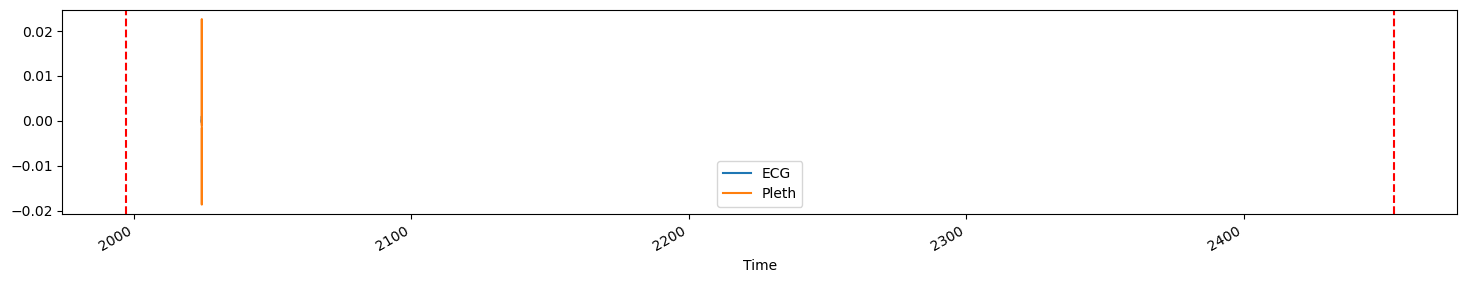

In [99]:
# Define events for specific event types (label value above threshold: 0)
# , df_subset['Limb Movement (Right)']
events3 = nk.events_find(df_subset[event_type], threshold=0, threshold_keep='above')
print(events3)
plot = nk.events_plot(events3, df_subset[['ECG', 'Pleth']])


{'onset': array([     0,  14132, 181228]), 'duration': array([  9882, 162724,   3093]), 'label': array(['1', '2', '3'], dtype='<U21')}


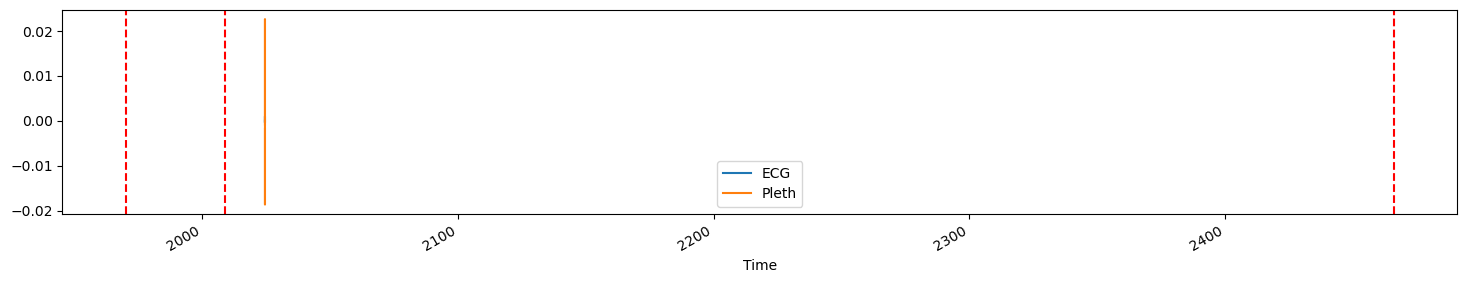

In [110]:
events4 = nk.events_find(df_subset[event_type], threshold=0, threshold_keep='below')
print(events4)
plot = nk.events_plot(events4, df_subset[['ECG', 'Pleth']])

In [111]:
# Combine the arrays
combined_onset = np.concatenate((events3['onset'], events4['onset']))
combined_duration = np.concatenate((events3['duration'], events4['duration']))

# Sort the arrays based on the combined onset values
sorted_indices = np.argsort(combined_onset)
sorted_onset = combined_onset[sorted_indices]
sorted_duration = combined_duration[sorted_indices]
sorted_label = [str(i+1) for i in range(len(sorted_onset))]


# Create the merged dictionary
merged_events = {
    'onset': sorted_onset,
    'duration': sorted_duration,
    'label': sorted_label
}

print(merged_events)


{'onset': array([     0,   9882,  14132, 176856, 181228]), 'duration': array([  9882,   4250, 162724,   4372,   3093]), 'label': ['1', '2', '3', '4', '5']}


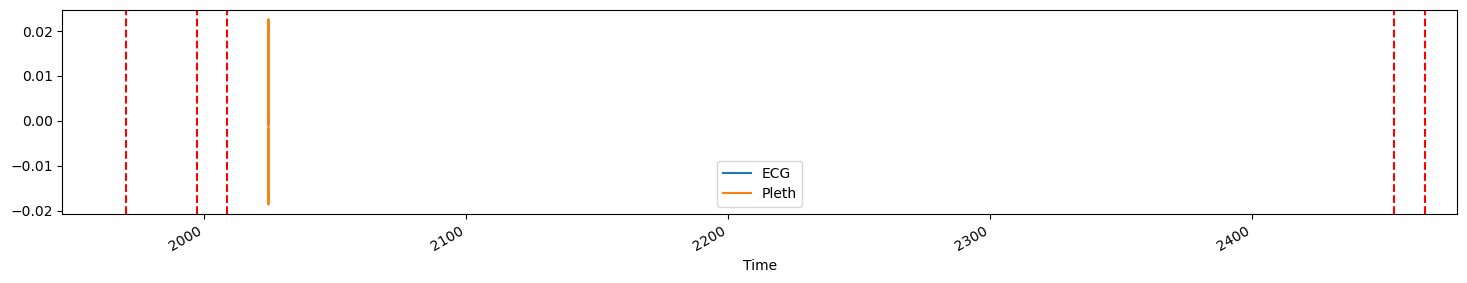

In [113]:
plot = nk.events_plot(merged_events, df_subset[['ECG', 'Pleth']])

#### Process the Signals

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

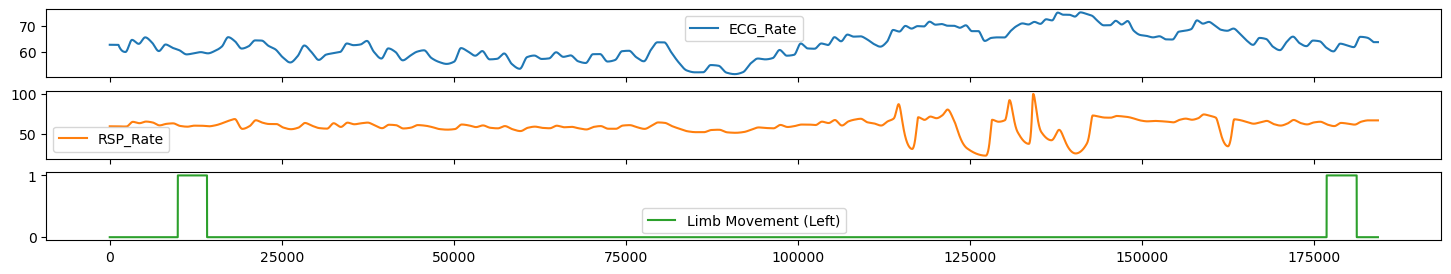

In [101]:
# Process the signal
data_clean, info = nk.bio_process(ecg=df_subset["ECG"], 
                                  rsp=df_subset["Pleth"],
                                  keep=df_subset[event_type],  
                                  sampling_rate=1024)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", event_type]].plot(subplots=True)

#### Create Epochs

In [114]:
# Build and plot epochs
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=-30, epochs_end=30)

In [117]:
for epoch_index, epoch in epochs.items():
    for attribute, value in epoch.items():
        print(f"  {attribute}")
    print("\n")  # Adds a newline for better readability between epochs

  ECG_Raw
  ECG_Clean
  ECG_Rate
  ECG_Quality
  ECG_R_Peaks
  ECG_P_Peaks
  ECG_P_Onsets
  ECG_P_Offsets
  ECG_Q_Peaks
  ECG_R_Onsets
  ECG_R_Offsets
  ECG_S_Peaks
  ECG_T_Peaks
  ECG_T_Onsets
  ECG_T_Offsets
  ECG_Phase_Atrial
  ECG_Phase_Completion_Atrial
  ECG_Phase_Ventricular
  ECG_Phase_Completion_Ventricular
  RSP_Raw
  RSP_Clean
  RSP_Amplitude
  RSP_Rate
  RSP_RVT
  RSP_Phase
  RSP_Phase_Completion
  RSP_Symmetry_PeakTrough
  RSP_Symmetry_RiseDecay
  RSP_Peaks
  RSP_Troughs
  Limb Movement (Left)
  RSA_P2T
  RSA_Gates
  Index
  Label


  ECG_Raw
  ECG_Clean
  ECG_Rate
  ECG_Quality
  ECG_R_Peaks
  ECG_P_Peaks
  ECG_P_Onsets
  ECG_P_Offsets
  ECG_Q_Peaks
  ECG_R_Onsets
  ECG_R_Offsets
  ECG_S_Peaks
  ECG_T_Peaks
  ECG_T_Onsets
  ECG_T_Offsets
  ECG_Phase_Atrial
  ECG_Phase_Completion_Atrial
  ECG_Phase_Ventricular
  ECG_Phase_Completion_Ventricular
  RSP_Raw
  RSP_Clean
  RSP_Amplitude
  RSP_Rate
  RSP_RVT
  RSP_Phase
  RSP_Phase_Completion
  RSP_Symmetry_PeakTrough
  RSP_Symm

In [118]:
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals
    print(epoch['Label'])

-30.000000    1
-29.999023    1
-29.998047    1
-29.997070    1
-29.996094    1
             ..
 29.996094    1
 29.997070    1
 29.998047    1
 29.999023    1
 30.000000    1
Name: Label, Length: 61440, dtype: string
-30.000000    2
-29.999023    2
-29.998047    2
-29.997070    2
-29.996094    2
             ..
 29.996094    2
 29.997070    2
 29.998047    2
 29.999023    2
 30.000000    2
Name: Label, Length: 61440, dtype: string
-30.000000    3
-29.999023    3
-29.998047    3
-29.997070    3
-29.996094    3
             ..
 29.996094    3
 29.997070    3
 29.998047    3
 29.999023    3
 30.000000    3
Name: Label, Length: 61440, dtype: string
-30.000000    4
-29.999023    4
-29.998047    4
-29.997070    4
-29.996094    4
             ..
 29.996094    4
 29.997070    4
 29.998047    4
 29.999023    4
 30.000000    4
Name: Label, Length: 61440, dtype: string
-30.000000    5
-29.999023    5
-29.998047    5
-29.997070    5
-29.996094    5
             ..
 29.996094    5
 29.997070    5


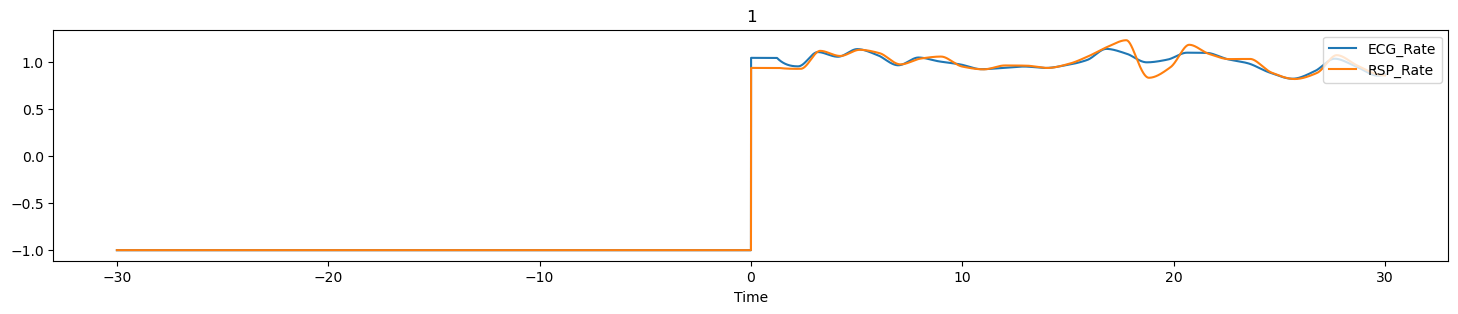

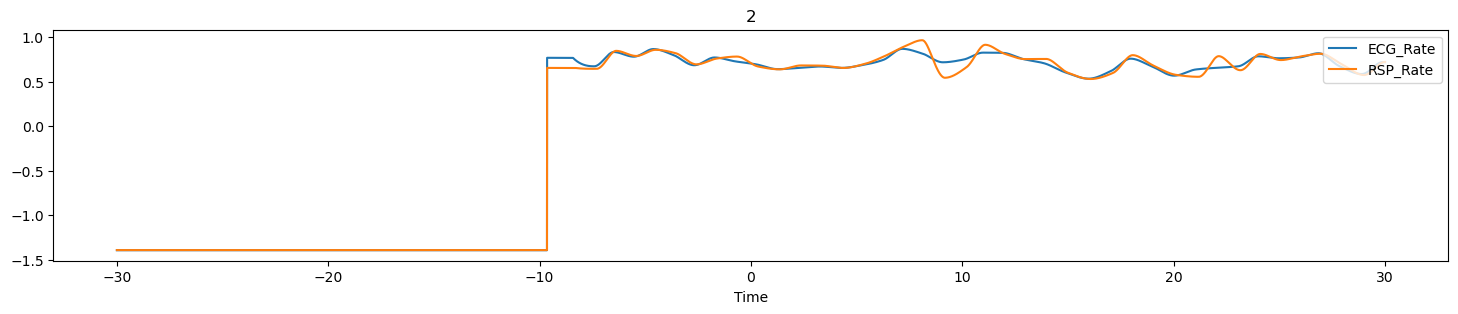

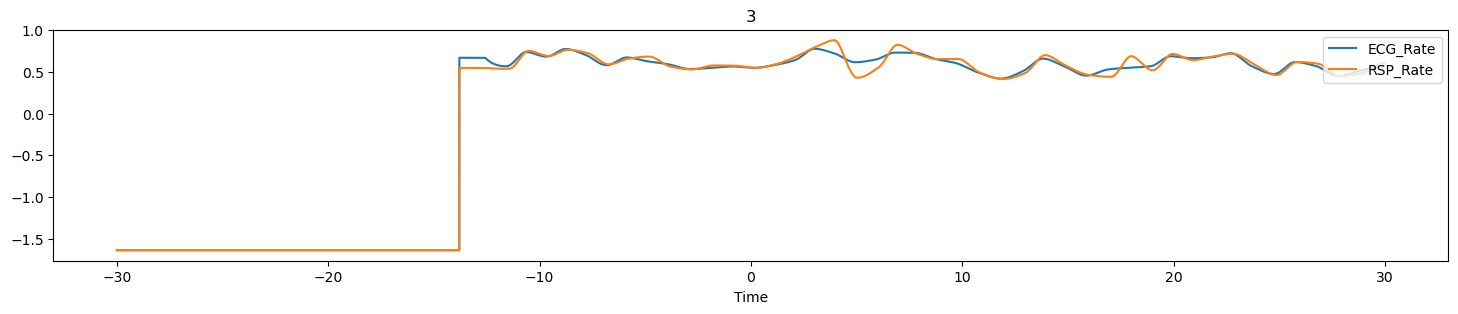

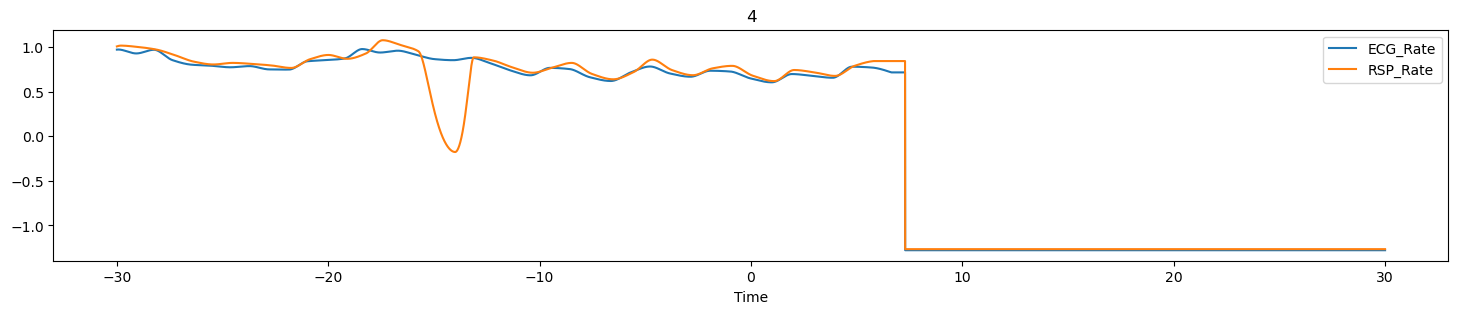

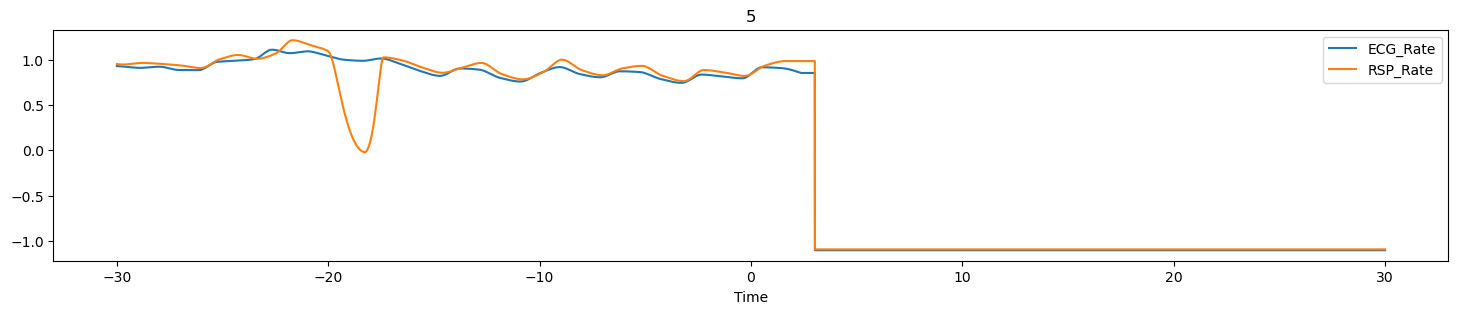

In [119]:
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals, "Stage Code"
    nk.signal_plot(epoch[['ECG_Rate', 'RSP_Rate']], 
                   title=epoch['Label'].values[0],  # Extract condition name
                   standardize=True)  

#### Interval Analysis

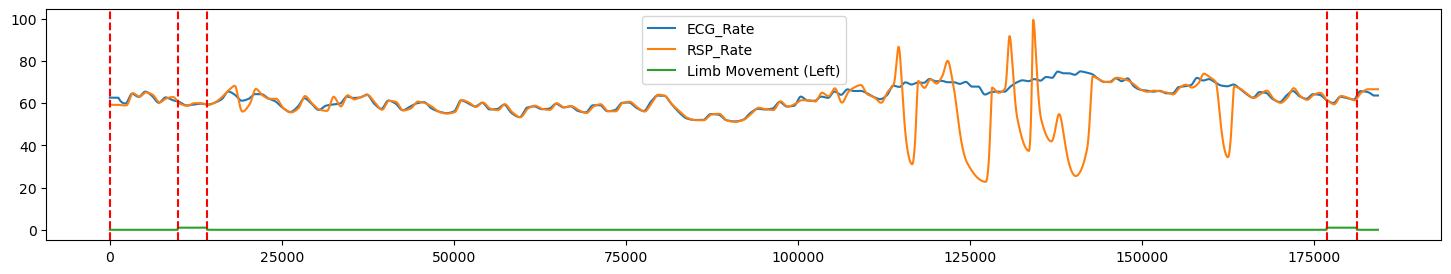

In [120]:
plot = nk.events_plot(merged_events,data_clean[["ECG_Rate", "RSP_Rate", event_type]])

In [141]:
print(merged_events)
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=0, epochs_end='from_events')

{'onset': array([     0,   9882,  14132, 176856, 181228]), 'duration': array([  9882,   4250, 162724,   4372,   3093]), 'label': ['1', '2', '3', '4', '5']}


In [149]:
epochs['1'] # less than 10s (9.65s)

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,...,RSP_Phase_Completion,RSP_Symmetry_PeakTrough,RSP_Symmetry_RiseDecay,RSP_Peaks,RSP_Troughs,Limb Movement (Left),RSA_P2T,RSA_Gates,Index,Label
0.000000,0.000017,0.000009,62.654006,0.699994,0,0,0,0,0,0,...,0.000000,0.517893,0.304223,0,0,0,12.695312,8.256173,0,1
0.000977,0.000015,0.000009,62.654006,0.699994,0,0,0,0,0,0,...,0.000000,0.517893,0.304223,0,0,0,12.695312,8.256173,1,1
0.001953,0.000013,0.000008,62.654006,0.699994,0,0,0,0,0,0,...,0.000000,0.517893,0.304223,0,0,0,12.695312,8.256173,2,1
0.002930,0.000011,0.000008,62.654006,0.699994,0,0,0,0,0,0,...,0.000000,0.517893,0.304223,0,0,0,12.695312,8.256173,3,1
0.003907,0.000009,0.000008,62.654006,0.699994,0,0,0,0,0,0,...,0.000000,0.517893,0.304223,0,0,0,12.695312,8.256173,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.646484,0.000003,-0.000030,60.795312,0.937599,0,0,0,0,0,0,...,0.492154,0.530930,0.311554,0,0,0,12.695312,8.256173,9877,1
9.647461,0.000013,-0.000029,60.794354,0.937633,0,0,0,0,0,0,...,0.493581,0.530927,0.311523,0,0,0,12.695312,8.256173,9878,1
9.648437,0.000018,-0.000029,60.793394,0.937666,0,0,0,0,0,0,...,0.495007,0.530923,0.311492,0,0,0,12.695312,8.256173,9879,1
9.649414,0.000018,-0.000029,60.792435,0.937699,0,0,0,0,0,0,...,0.496434,0.530920,0.311461,0,0,0,12.695312,8.256173,9880,1


In [150]:
epochs['3'] # greater than 10s (158s)

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,...,RSP_Phase_Completion,RSP_Symmetry_PeakTrough,RSP_Symmetry_RiseDecay,RSP_Peaks,RSP_Troughs,Limb Movement (Left),RSA_P2T,RSA_Gates,Index,Label
0.000000,4.558633e-06,3.657385e-06,59.383408,0.814330,0,0,0,0,0,0,...,0.674682,0.525526,0.313449,0,0,0,12.695312,8.256173,14132,3
0.000977,8.945602e-06,2.290931e-06,59.383109,0.814317,0,0,0,0,0,0,...,0.676096,0.525521,0.313442,0,0,0,12.695312,8.256173,14133,3
0.001953,1.173037e-05,8.544938e-07,59.382812,0.814305,0,0,0,0,0,0,...,0.677511,0.525516,0.313436,0,0,0,12.695312,8.256173,14134,3
0.002930,1.230259e-05,-6.689968e-07,59.382517,0.814294,0,0,0,0,0,0,...,0.678925,0.525512,0.313429,0,0,0,12.695312,8.256173,14135,3
0.003906,1.096742e-05,-2.290318e-06,59.382223,0.814283,0,0,0,0,0,0,...,0.680339,0.525507,0.313422,0,0,0,12.695312,8.256173,14136,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158.906250,1.602007e-04,2.109644e-04,61.480307,0.921902,0,0,0,0,0,0,...,0.860704,0.532800,0.308330,0,0,0,0.000000,8.126957,176851,3
158.907227,1.021401e-04,1.671669e-04,61.478534,0.921740,0,0,0,0,0,0,...,0.862170,0.532816,0.308310,0,0,0,0.000000,8.126957,176852,3
158.908203,4.976349e-05,1.232127e-04,61.476759,0.921578,0,0,0,0,0,0,...,0.863636,0.532832,0.308290,0,0,0,0.000000,8.126957,176853,3
158.909180,-9.727626e-07,7.955027e-05,61.474984,0.921416,0,0,0,0,0,0,...,0.865103,0.532847,0.308270,0,0,0,0.000000,8.126957,176854,3


In [157]:
epochs['4'] # less than 10s (4.3s)

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,...,RSP_Phase_Completion,RSP_Symmetry_PeakTrough,RSP_Symmetry_RiseDecay,RSP_Peaks,RSP_Troughs,Limb Movement (Left),RSA_P2T,RSA_Gates,Index,Label
0.000000,-0.000106,-0.000005,61.471430,0.921091,0,0,0,0,0,0,...,0.868035,0.532879,0.308230,0,0,1,0.0,8.126957,176856,4
0.000977,-0.000161,-0.000045,61.469651,0.920928,0,0,0,0,0,0,...,0.869501,0.532895,0.308210,0,0,1,0.0,8.126957,176857,4
0.001954,-0.000215,-0.000083,61.467871,0.920764,0,0,0,0,0,0,...,0.870968,0.532911,0.308190,0,0,1,0.0,8.126957,176858,4
0.002930,-0.000268,-0.000119,61.466091,0.920600,0,0,0,0,0,0,...,0.872434,0.532926,0.308170,0,0,1,0.0,8.126957,176859,4
0.003907,-0.000320,-0.000152,61.464309,0.920436,0,0,0,0,0,0,...,0.873900,0.532942,0.308151,0,0,1,0.0,8.126957,176860,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.265624,-0.000043,-0.000034,63.300945,0.810299,0,0,0,0,0,0,...,0.967105,0.545264,0.322406,0,0,1,0.0,8.126957,181223,4
4.266601,-0.000043,-0.000035,63.307127,0.810381,0,0,0,0,0,0,...,0.970395,0.545265,0.322407,0,0,1,0.0,8.126957,181224,4
4.267578,-0.000044,-0.000036,63.313313,0.810462,0,0,0,0,0,0,...,0.973684,0.545265,0.322407,0,0,1,0.0,8.126957,181225,4
4.268554,-0.000046,-0.000037,63.319503,0.810544,0,0,0,0,0,0,...,0.976974,0.545266,0.322408,0,0,1,0.0,8.126957,181226,4


In [159]:
# Analyze
nk.ecg_intervalrelated(epochs['3'])

,ECG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,62.734428,[[979.355421686747]],[[89.23499891316872]],[[69.28621060440503]],[[65.63069597401312]],[[nan]],[[nan]],[[nan]],[[nan]],[[34.22598693709478]],...,[[1.0456197585275995]],[[6.889923015606077]],[[0.7769118676636421]],[[1.1376079896240359]],[[1.2961643421249214]],[[1.7578941465498208]],[[1.6321019452323284]],[[1.638253015382051]],[[2.534658764395527]],[[0.6219912773425117]]


In [156]:
nk.rsp_intervalrelated(epochs['3'])

,RSP_Rate_Mean,RRV_RMSSD,RRV_MeanBB,RRV_SDBB,RRV_SDSD,RRV_CVBB,RRV_CVSD,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,...,RAV_Mean,RAV_SD,RAV_RMSSD,RAV_CVSD,RSP_RVT,RSP_Symmetry_PeakTrough,RSP_Symmetry_RiseDecay,RSP_Phase_Duration_Inspiration,RSP_Phase_Duration_Expiration,RSP_Phase_Duration_Ratio
0,59.309316,308.360126,1042.477419,249.096297,309.365871,0.238946,0.295795,1010.0,106.7472,0.10569,...,0.008122,0.004117,0.002413,0.297112,0.000754,0.523687,0.334671,0.000343,0.000673,0.50877


## Pnea

In [214]:
event_type = 'Hypopnea'

### The Dataset

In [215]:
df_sleep_events = xml_processor.events
df_sleep_events


,Name,Actual Start (sec),Duration,Start,End,Input
0,Mixed Apnea,91.67,0.24,2024-06-20 22:04:05.670,2024-06-20 22:04:05.910,Airflow
1,Limb Movement (Left),336.65,2.15,2024-06-20 22:08:10.650,2024-06-20 22:08:12.800,Leg/L
2,Limb Movement (Right),336.61,2.24,2024-06-20 22:08:10.610,2024-06-20 22:08:12.850,Leg/R
3,Limb Movement (Left),499.71,2.27,2024-06-20 22:10:53.710,2024-06-20 22:10:55.980,Leg/L
4,Limb Movement (Right),500.37,1.69,2024-06-20 22:10:54.370,2024-06-20 22:10:56.060,Leg/R
...,...,...,...,...,...,...
601,PLM (Right),27023.70,2.02,2024-06-21 05:32:57.700,2024-06-21 05:32:59.720,Leg/R
602,Limb Movement (Right),27026.70,2.60,2024-06-21 05:33:00.700,2024-06-21 05:33:03.300,Leg/R
603,Limb Movement (Right),27099.80,2.15,2024-06-21 05:34:13.800,2024-06-21 05:34:15.950,Leg/R
604,Limb Movement (Right),27234.00,1.94,2024-06-21 05:36:28.000,2024-06-21 05:36:29.940,Leg/R


In [216]:
events = xml_processor.events['Name'].values
print(np.unique(events))

['Arousal (ARO Limb)' 'Arousal (ARO PLM)' 'Arousal (ARO RES)'
 'Arousal (ARO SPONT)' 'Central Apnea' 'Hypopnea' 'Limb Movement (Left)'
 'Limb Movement (Right)' 'Mixed Apnea' 'Obstructive Apnea' 'PLM (Left)'
 'PLM (Right)' 'SpO2 artifact' 'SpO2 desaturation']


In [217]:
pnea_df = df_sleep_events[df_sleep_events['Name'].str.contains('pnea')]
pnea_df

,Name,Actual Start (sec),Duration,Start,End,Input
0,Mixed Apnea,91.67,0.24,2024-06-20 22:04:05.670,2024-06-20 22:04:05.910,Airflow
6,Hypopnea,744.20,11.93,2024-06-20 22:14:58.200,2024-06-20 22:15:10.130,Airflow
7,Hypopnea,768.40,15.72,2024-06-20 22:15:22.400,2024-06-20 22:15:38.120,Airflow
12,Hypopnea,1173.98,18.90,2024-06-20 22:22:07.980,2024-06-20 22:22:26.880,Airflow
90,Hypopnea,4887.72,28.01,2024-06-20 23:24:01.720,2024-06-20 23:24:29.730,Airflow
95,Hypopnea,4969.78,37.79,2024-06-20 23:25:23.780,2024-06-20 23:26:01.570,Airflow
98,Hypopnea,5033.43,24.20,2024-06-20 23:26:27.430,2024-06-20 23:26:51.630,Airflow
103,Hypopnea,5107.18,31.49,2024-06-20 23:27:41.180,2024-06-20 23:28:12.670,Airflow
107,Hypopnea,5254.62,21.88,2024-06-20 23:30:08.620,2024-06-20 23:30:30.500,Airflow
340,Hypopnea,15605.60,25.52,2024-06-21 02:22:39.600,2024-06-21 02:23:05.120,Airflow


#### Prepare the data (Time window)

In [218]:
# 2024-06-20 22:14:58.200	2024-06-20 22:15:10.130
start_datetime = datetime(2024, 6, 20, 22, 13, 00)
end_datetime = datetime(2024, 6, 20, 22, 16, 00) 

start_time = start_datetime
end_time = end_datetime

filtered_df = df.loc[start_time:end_time]
# Make a df subset with all the columns except: 
# 'ECG', 'Pleth', 'Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 
# 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)'
columns_to_drop = ['Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)']
df_subset = filtered_df.drop(columns=columns_to_drop)
print(df_subset.head())

                                 ECG     Pleth  Mixed Apnea  \
Time                                                          
2024-06-20 22:13:00.000000 -0.000024  0.000198            0   
2024-06-20 22:13:00.000977 -0.000024  0.000198            0   
2024-06-20 22:13:00.001953 -0.000023  0.000198            0   
2024-06-20 22:13:00.002930 -0.000023  0.000198            0   
2024-06-20 22:13:00.003906 -0.000023  0.000198            0   

                            Limb Movement (Left)  Limb Movement (Right)  \
Time                                                                      
2024-06-20 22:13:00.000000                     0                      0   
2024-06-20 22:13:00.000977                     0                      0   
2024-06-20 22:13:00.001953                     0                      0   
2024-06-20 22:13:00.002930                     0                      0   
2024-06-20 22:13:00.003906                     0                      0   

                            SpO2

#### Prepare the data (add columns)

In [219]:
def add_sleep_stage_column(df_subset, df_sleep_stages):
    # Create a new column in df_subset to store the sleep stage code
    df_subset['Stage Code'] = None

    # Iterate over each row in df_sleep_stages
    for index, row in df_sleep_stages.iterrows():
        stage_start_time = row['Start Time']
        stage_end_time = stage_start_time + timedelta(seconds=30)

        # Find the rows in df_subset that fall within the current sleep stage interval
        mask = (df_subset.index >= stage_start_time) & (df_subset.index < stage_end_time)
        
        # Assign the sleep stage code to the corresponding rows in df_subset
        df_subset.loc[mask, 'Stage Code'] = row['Sleep Stage Code']
        # df_subset.loc[mask, 'Sleep Stage'] = row['Sleep Stage']
        # df_subset.loc[mask, 'Time (seconds)'] = row['Time (seconds)']
        # df_subset.loc[mask, 'Duration'] = row['Duration']
    
    return df_subset

# Example usage
# Apply the function to add the sleep stage column
df_subset_with_sleep_stage = add_sleep_stage_column(df_subset, df_sleep_stages)

print(df_subset_with_sleep_stage)
print(df_subset_with_sleep_stage['Stage Code'].value_counts())

                                 ECG     Pleth  Mixed Apnea  \
Time                                                          
2024-06-20 22:13:00.000000 -0.000024  0.000198            0   
2024-06-20 22:13:00.000977 -0.000024  0.000198            0   
2024-06-20 22:13:00.001953 -0.000023  0.000198            0   
2024-06-20 22:13:00.002930 -0.000023  0.000198            0   
2024-06-20 22:13:00.003906 -0.000023  0.000198            0   
...                              ...       ...          ...   
2024-06-20 22:15:59.996094 -0.000015 -0.001877            0   
2024-06-20 22:15:59.997070 -0.000016 -0.001877            0   
2024-06-20 22:15:59.998047 -0.000017 -0.001907            0   
2024-06-20 22:15:59.999023 -0.000020 -0.001907            0   
2024-06-20 22:16:00.000000 -0.000022 -0.001907            0   

                            Limb Movement (Left)  Limb Movement (Right)  \
Time                                                                      
2024-06-20 22:13:00.000000    

### Find Events (Auto)

#### Process and plot the events

In [220]:
# Check which columns of the df_suset have non-zero values within the given time range and return the column names
def check_non_zero_columns(df, start_datetime, end_datetime):
    # Filter rows within the time range
    df = df.loc[start_datetime:end_datetime]
    
    # Define the list of columns to extract
    columns = df.columns
    
    # Check which columns have non-zero values
    non_zero_columns = df.columns[(df != 0).any()]
    
    return non_zero_columns

# Example usage: 
non_zero_columns = check_non_zero_columns(df, start_datetime, end_datetime)
print(non_zero_columns)

Index(['ECG', 'Pleth', 'REM Sleep', 'Limb Movement (Left)',
       'Limb Movement (Right)', 'SpO2 desaturation', 'Hypopnea'],
      dtype='object')


{'onset': array([120013, 144794]), 'duration': array([14265, 18145]), 'label': array(['1', '2'], dtype='<U21')}


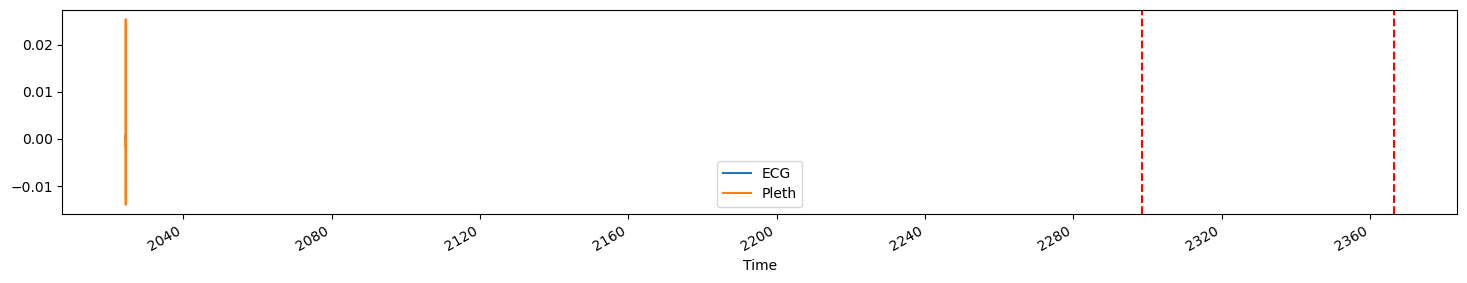

In [221]:
# Define events for specific event types (label value above threshold: 0)
# , df_subset['Limb Movement (Right)']
events3 = nk.events_find(df_subset[event_type], threshold=0, threshold_keep='above')
print(events3)
plot = nk.events_plot(events3, df_subset[['ECG', 'Pleth']])


{'onset': array([     0, 134278, 162939]), 'duration': array([120013,  10516,  21382]), 'label': array(['1', '2', '3'], dtype='<U21')}


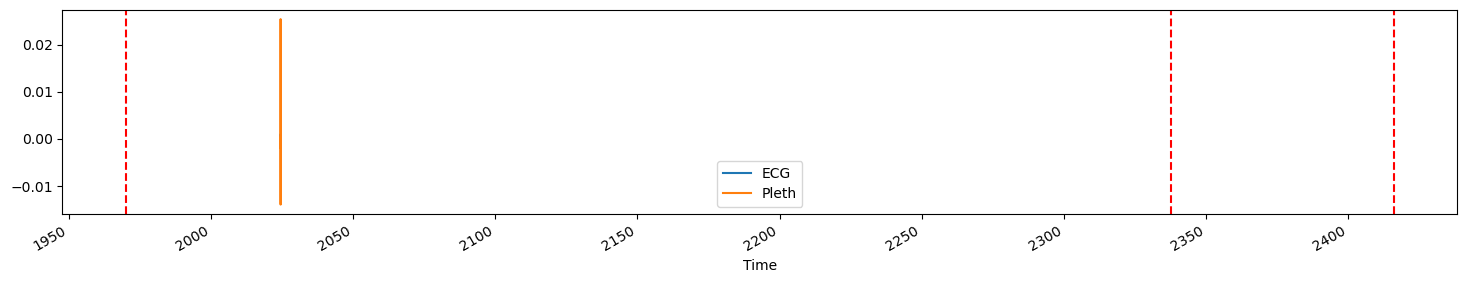

In [222]:
events4 = nk.events_find(df_subset[event_type], threshold=0, threshold_keep='below')
print(events4)
plot = nk.events_plot(events4, df_subset[['ECG', 'Pleth']])

In [223]:
# Combine the arrays
combined_onset = np.concatenate((events3['onset'], events4['onset']))
combined_duration = np.concatenate((events3['duration'], events4['duration']))

# Sort the arrays based on the combined onset values
sorted_indices = np.argsort(combined_onset)
sorted_onset = combined_onset[sorted_indices]
sorted_duration = combined_duration[sorted_indices]
sorted_label = [str(i+1) for i in range(len(sorted_onset))]


# Create the merged dictionary
merged_events = {
    'onset': sorted_onset,
    'duration': sorted_duration,
    'label': sorted_label
}

print(merged_events)


{'onset': array([     0, 120013, 134278, 144794, 162939]), 'duration': array([120013,  14265,  10516,  18145,  21382]), 'label': ['1', '2', '3', '4', '5']}


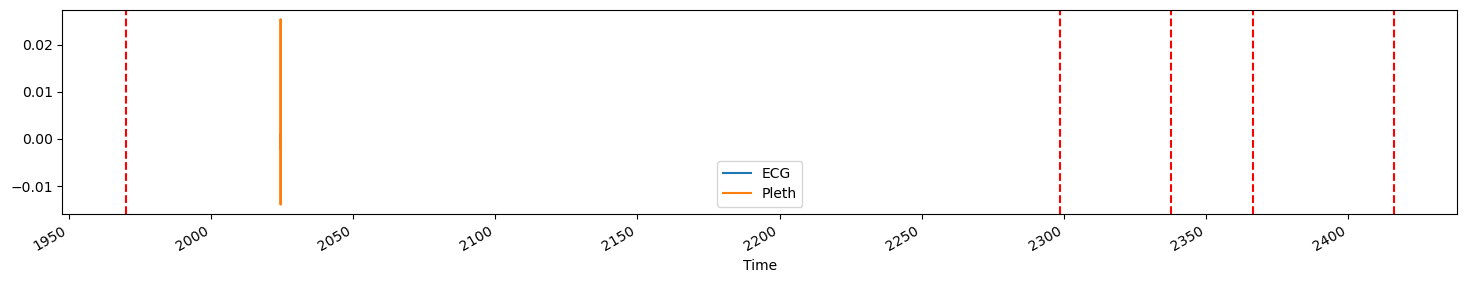

In [224]:
plot = nk.events_plot(merged_events, df_subset[['ECG', 'Pleth']])

#### Process the Signals

In [225]:
df_subset["ECG"].describe()

count    1.843210e+05
mean    -3.128499e-08
std      1.188519e-04
min     -5.201610e-04
25%     -3.988327e-05
50%     -2.576867e-05
75%      7.228962e-06
max      9.897192e-04
Name: ECG, dtype: float64

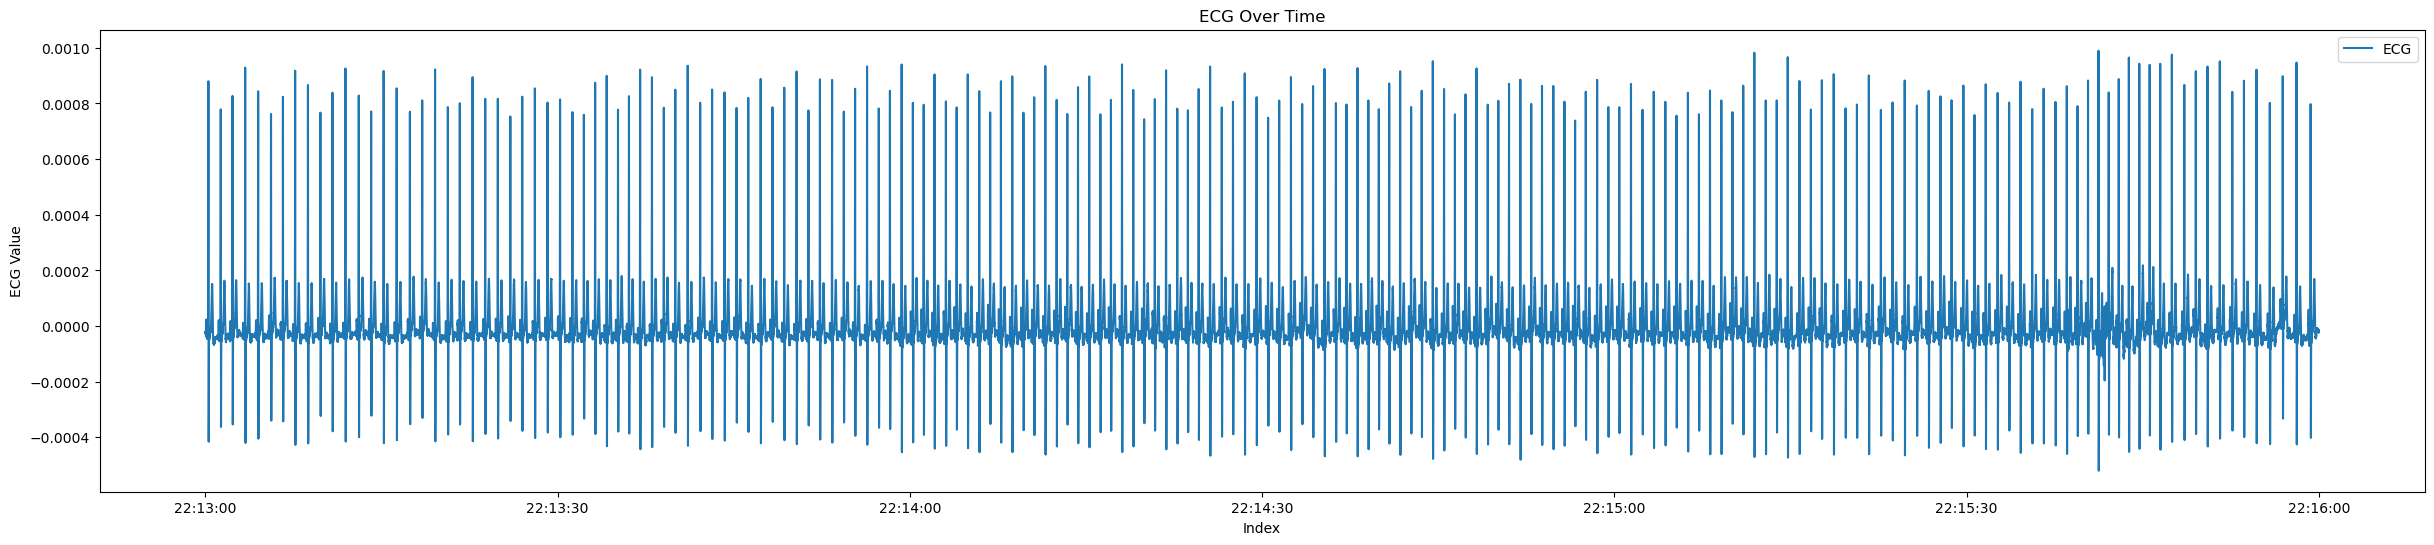

In [226]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset['ECG'], label='ECG')  # Plot the ECG column
plt.title('ECG Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('ECG Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

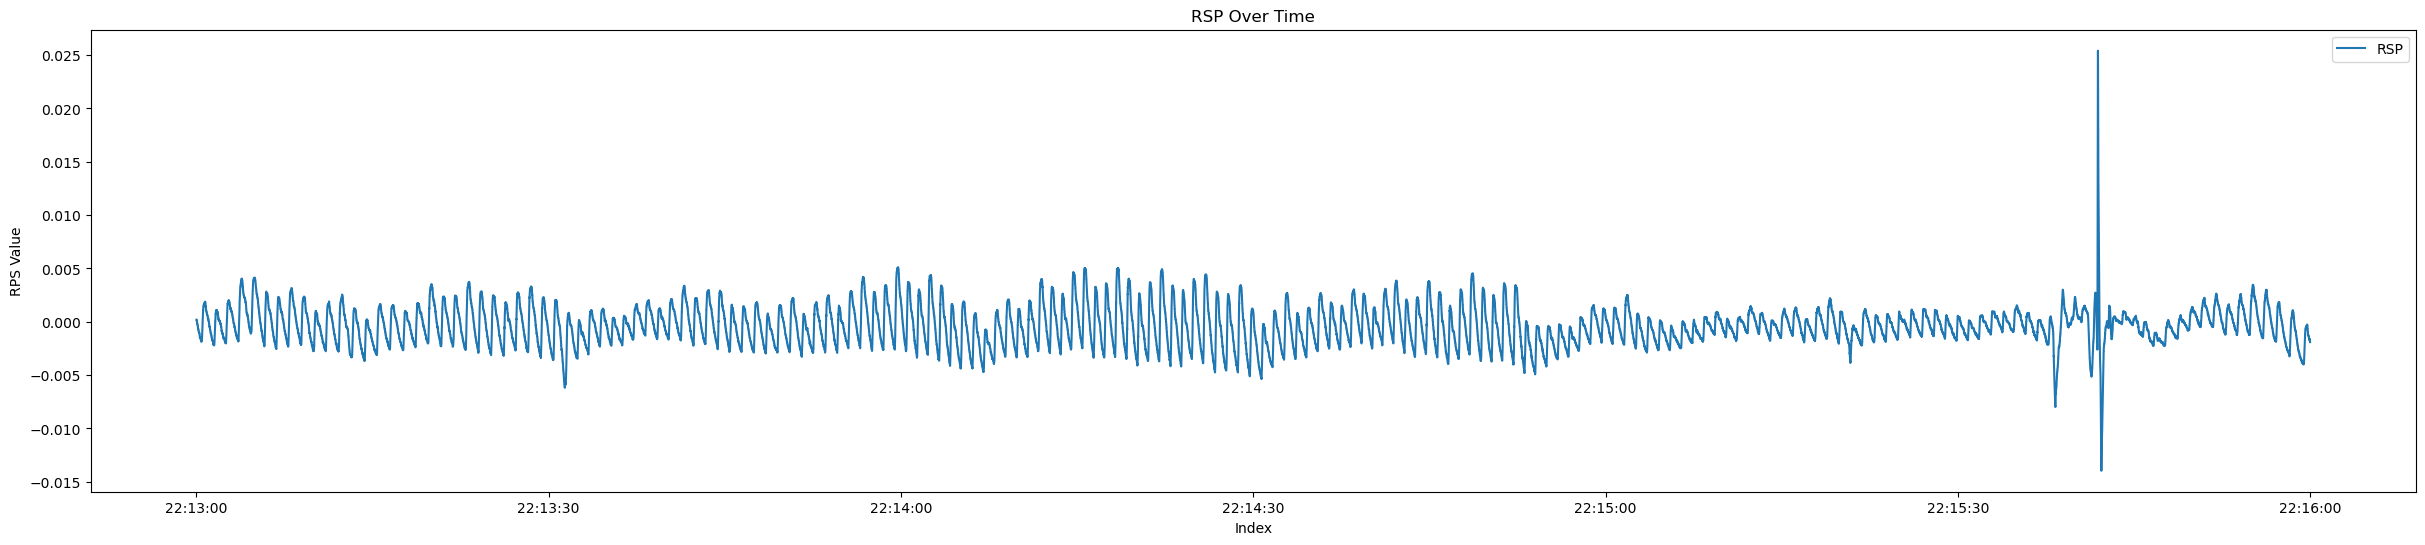

In [227]:
plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset['Pleth'], label='RSP')  # Plot the ECG column
plt.title('RSP Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('RPS Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

array([<Axes: >, <Axes: >], dtype=object)

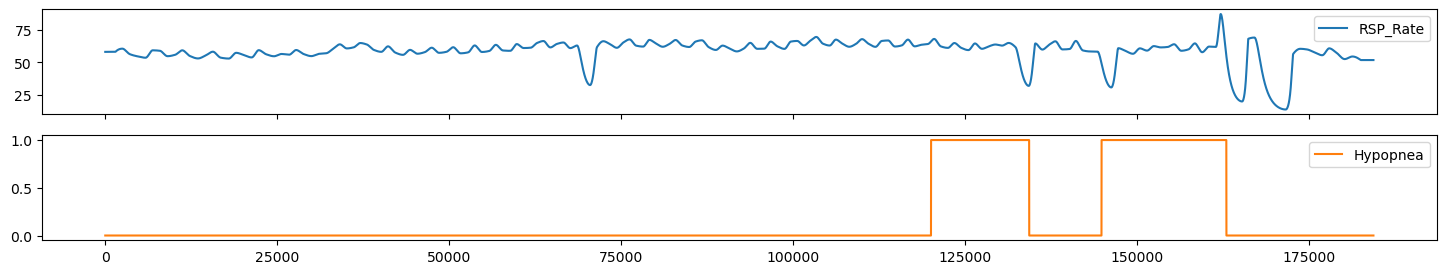

In [228]:
# Process the signal
data_clean, info = nk.bio_process(
                                  rsp=df_subset["Pleth"],
                                  keep=df_subset[event_type],  
                                  sampling_rate=1024)

# Visualize some of the channels
data_clean[["RSP_Rate", event_type]].plot(subplots=True)

#### Create Epochs

In [229]:
# Build and plot epochs
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=-30, epochs_end=30)

In [230]:
for epoch_index, epoch in epochs.items():
    for attribute, value in epoch.items():
        print(f"  {attribute}")
    print("\n")  # Adds a newline for better readability between epochs

  RSP_Raw
  RSP_Clean
  RSP_Amplitude
  RSP_Rate
  RSP_RVT
  RSP_Phase
  RSP_Phase_Completion
  RSP_Symmetry_PeakTrough
  RSP_Symmetry_RiseDecay
  RSP_Peaks
  RSP_Troughs
  Hypopnea
  Index
  Label


  RSP_Raw
  RSP_Clean
  RSP_Amplitude
  RSP_Rate
  RSP_RVT
  RSP_Phase
  RSP_Phase_Completion
  RSP_Symmetry_PeakTrough
  RSP_Symmetry_RiseDecay
  RSP_Peaks
  RSP_Troughs
  Hypopnea
  Index
  Label


  RSP_Raw
  RSP_Clean
  RSP_Amplitude
  RSP_Rate
  RSP_RVT
  RSP_Phase
  RSP_Phase_Completion
  RSP_Symmetry_PeakTrough
  RSP_Symmetry_RiseDecay
  RSP_Peaks
  RSP_Troughs
  Hypopnea
  Index
  Label


  RSP_Raw
  RSP_Clean
  RSP_Amplitude
  RSP_Rate
  RSP_RVT
  RSP_Phase
  RSP_Phase_Completion
  RSP_Symmetry_PeakTrough
  RSP_Symmetry_RiseDecay
  RSP_Peaks
  RSP_Troughs
  Hypopnea
  Index
  Label


  RSP_Raw
  RSP_Clean
  RSP_Amplitude
  RSP_Rate
  RSP_RVT
  RSP_Phase
  RSP_Phase_Completion
  RSP_Symmetry_PeakTrough
  RSP_Symmetry_RiseDecay
  RSP_Peaks
  RSP_Troughs
  Hypopnea
  Index
  Label




In [231]:
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals
    print(epoch['Label'])

-30.000000    1
-29.999023    1
-29.998047    1
-29.997070    1
-29.996094    1
             ..
 29.996094    1
 29.997070    1
 29.998047    1
 29.999023    1
 30.000000    1
Name: Label, Length: 61440, dtype: string
-30.000000    2
-29.999023    2
-29.998047    2
-29.997070    2
-29.996094    2
             ..
 29.996094    2
 29.997070    2
 29.998047    2
 29.999023    2
 30.000000    2
Name: Label, Length: 61440, dtype: string
-30.000000    3
-29.999023    3
-29.998047    3
-29.997070    3
-29.996094    3
             ..
 29.996094    3
 29.997070    3
 29.998047    3
 29.999023    3
 30.000000    3
Name: Label, Length: 61440, dtype: string
-30.000000    4
-29.999023    4
-29.998047    4
-29.997070    4
-29.996094    4
             ..
 29.996094    4
 29.997070    4
 29.998047    4
 29.999023    4
 30.000000    4
Name: Label, Length: 61440, dtype: string
-30.000000    5
-29.999023    5
-29.998047    5
-29.997070    5
-29.996094    5
             ..
 29.996094    5
 29.997070    5


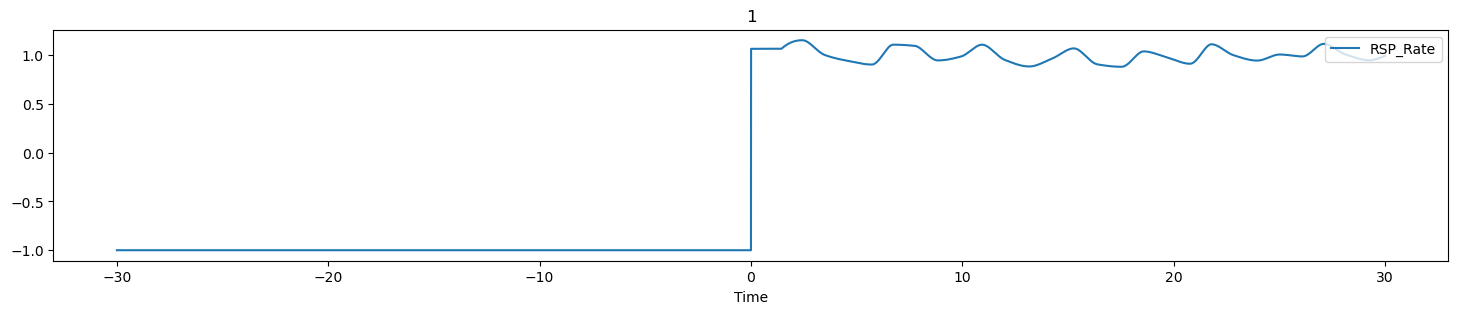

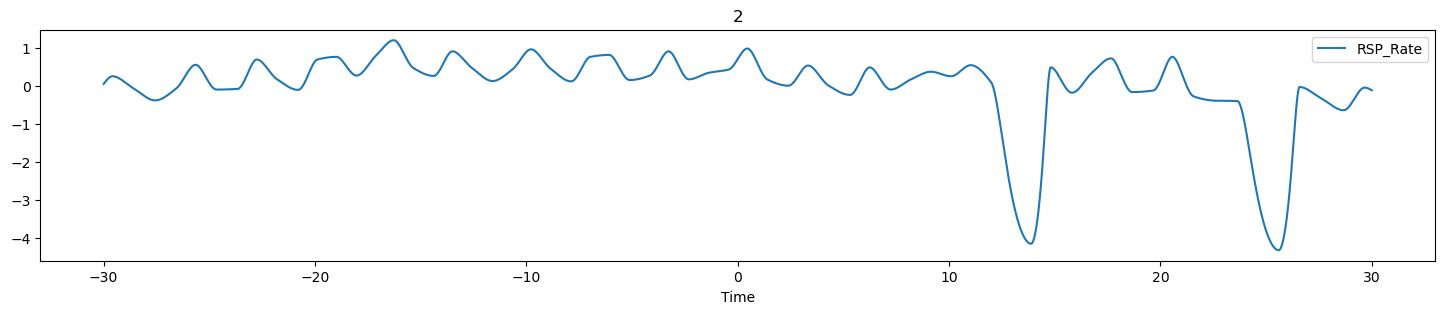

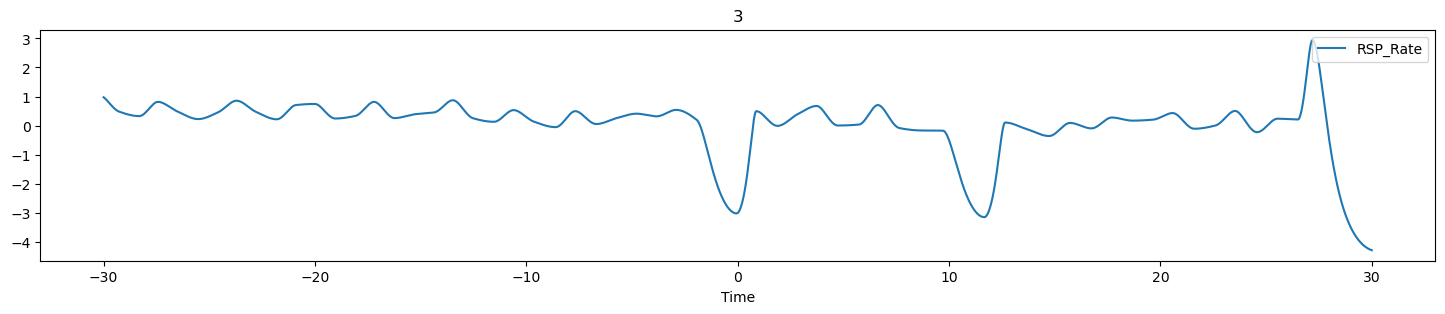

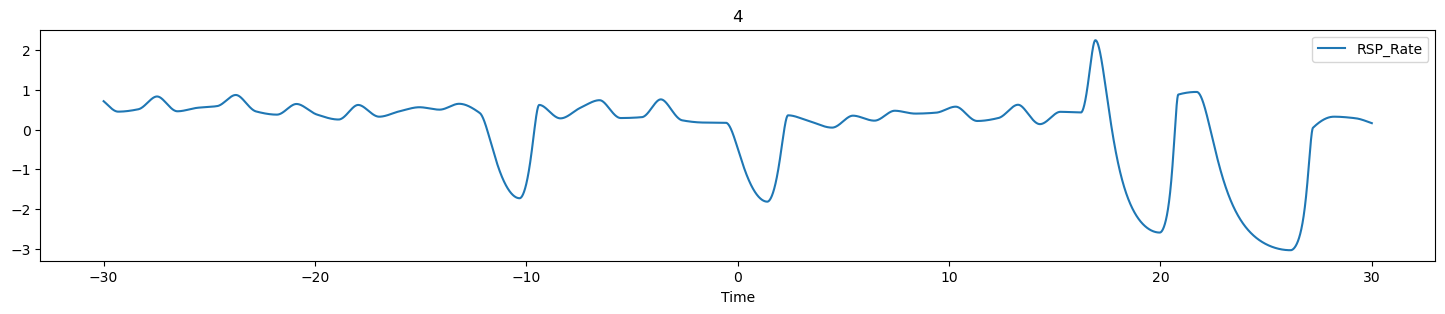

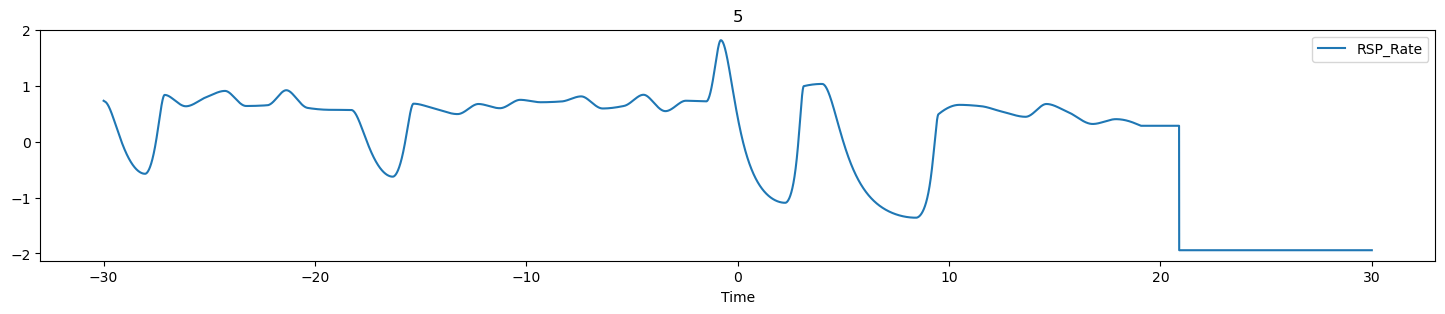

In [232]:
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals, "Stage Code"
    nk.signal_plot(epoch[['RSP_Rate']], 
                   title=epoch['Label'].values[0],  # Extract condition name
                   standardize=True)  

#### Interval Analysis

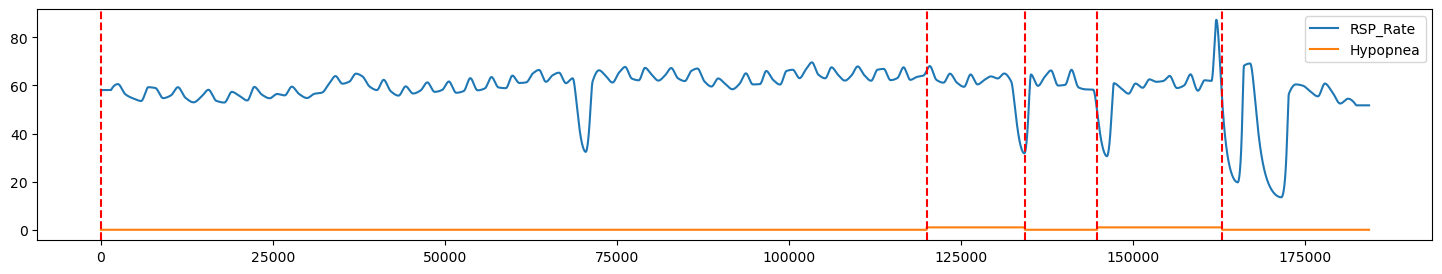

In [233]:
plot = nk.events_plot(merged_events,data_clean[["RSP_Rate", event_type]])

In [234]:
print(merged_events)
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=0, epochs_end='from_events')

{'onset': array([     0, 120013, 134278, 144794, 162939]), 'duration': array([120013,  14265,  10516,  18145,  21382]), 'label': ['1', '2', '3', '4', '5']}


In [235]:
nk.rsp_intervalrelated(epochs)

,Label,RSP_Rate_Mean,RRV_RMSSD,RRV_MeanBB,RRV_SDBB,RRV_SDSD,RRV_CVBB,RRV_CVSD,RRV_MedianBB,RRV_MadBB,...,RAV_Mean,RAV_SD,RAV_RMSSD,RAV_CVSD,RSP_RVT,RSP_Symmetry_PeakTrough,RSP_Symmetry_RiseDecay,RSP_Phase_Duration_Inspiration,RSP_Phase_Duration_Expiration,RSP_Phase_Duration_Ratio
1,1,60.389770,131.630279,1018.103448,106.059325,132.205407,0.104173,0.129290,1001.0,69.6822,...,0.005142,0.001374,0.001079,0.209737,0.000436,0.510851,0.310607,0.000309,0.000683,0.452485
2,2,60.175482,274.702718,1057.615385,264.723295,274.823070,0.250302,0.259738,987.0,34.0998,...,0.002720,0.000751,0.000750,0.275795,0.000198,0.510488,0.287850,0.000290,0.000741,0.390657
3,3,59.871023,68.184492,1004.111111,51.108816,72.802939,0.050900,0.067905,1025.0,41.5128,...,0.002394,0.000614,0.000659,0.275244,0.000374,0.487191,0.327514,0.000309,0.000664,0.465454
4,4,58.885222,92.490360,993.562500,85.290850,93.394453,0.085843,0.093090,1004.0,42.9954,...,0.002592,0.001805,0.001789,0.690206,0.000253,0.485899,0.317036,0.000307,0.000683,0.449987
5,5,45.967784,1454.981987,1324.153846,972.776854,1519.473800,0.734640,1.098801,1072.0,83.0256,...,0.004562,0.004101,0.002967,0.650321,0.000593,0.492181,0.355126,0.000436,0.000848,0.514593


## Central Apnea

In [236]:
event_type = 'Central Apnea'

### The Dataset

In [237]:
df_sleep_events = xml_processor.events
df_sleep_events


,Name,Actual Start (sec),Duration,Start,End,Input
0,Mixed Apnea,91.67,0.24,2024-06-20 22:04:05.670,2024-06-20 22:04:05.910,Airflow
1,Limb Movement (Left),336.65,2.15,2024-06-20 22:08:10.650,2024-06-20 22:08:12.800,Leg/L
2,Limb Movement (Right),336.61,2.24,2024-06-20 22:08:10.610,2024-06-20 22:08:12.850,Leg/R
3,Limb Movement (Left),499.71,2.27,2024-06-20 22:10:53.710,2024-06-20 22:10:55.980,Leg/L
4,Limb Movement (Right),500.37,1.69,2024-06-20 22:10:54.370,2024-06-20 22:10:56.060,Leg/R
...,...,...,...,...,...,...
601,PLM (Right),27023.70,2.02,2024-06-21 05:32:57.700,2024-06-21 05:32:59.720,Leg/R
602,Limb Movement (Right),27026.70,2.60,2024-06-21 05:33:00.700,2024-06-21 05:33:03.300,Leg/R
603,Limb Movement (Right),27099.80,2.15,2024-06-21 05:34:13.800,2024-06-21 05:34:15.950,Leg/R
604,Limb Movement (Right),27234.00,1.94,2024-06-21 05:36:28.000,2024-06-21 05:36:29.940,Leg/R


In [238]:
events = xml_processor.events['Name'].values
print(np.unique(events))

['Arousal (ARO Limb)' 'Arousal (ARO PLM)' 'Arousal (ARO RES)'
 'Arousal (ARO SPONT)' 'Central Apnea' 'Hypopnea' 'Limb Movement (Left)'
 'Limb Movement (Right)' 'Mixed Apnea' 'Obstructive Apnea' 'PLM (Left)'
 'PLM (Right)' 'SpO2 artifact' 'SpO2 desaturation']


In [239]:
pnea_df = df_sleep_events[df_sleep_events['Name'].str.contains(event_type)]
pnea_df

,Name,Actual Start (sec),Duration,Start,End,Input
388,Central Apnea,19862.6,18.23,2024-06-21 03:33:36.600,2024-06-21 03:33:54.830,Airflow
391,Central Apnea,19899.2,11.27,2024-06-21 03:34:13.200,2024-06-21 03:34:24.470,Airflow


#### Prepare the data (Time window)

In [242]:
# 2024-06-21 03:33:36.600	2024-06-21 03:33:54.830
start_datetime = datetime(2024, 6, 21, 3, 33, 00)
end_datetime = datetime(2024, 6, 21, 3, 35, 00) 

start_time = start_datetime
end_time = end_datetime

filtered_df = df.loc[start_time:end_time]
# Make a df subset with all the columns except: 
# 'ECG', 'Pleth', 'Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 
# 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)'
columns_to_drop = ['Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)']
df_subset = filtered_df.drop(columns=columns_to_drop)
print(df_subset.head())

                                 ECG     Pleth  Mixed Apnea  \
Time                                                          
2024-06-21 03:33:00.000000 -0.000050  0.000748            0   
2024-06-21 03:33:00.000977 -0.000049  0.000717            0   
2024-06-21 03:33:00.001953 -0.000048  0.000717            0   
2024-06-21 03:33:00.002930 -0.000047  0.000717            0   
2024-06-21 03:33:00.003906 -0.000047  0.000687            0   

                            Limb Movement (Left)  Limb Movement (Right)  \
Time                                                                      
2024-06-21 03:33:00.000000                     0                      0   
2024-06-21 03:33:00.000977                     0                      0   
2024-06-21 03:33:00.001953                     0                      0   
2024-06-21 03:33:00.002930                     0                      0   
2024-06-21 03:33:00.003906                     0                      0   

                            SpO2

#### Prepare the data (add columns)

In [ ]:
def add_sleep_stage_column(df_subset, df_sleep_stages):
    # Create a new column in df_subset to store the sleep stage code
    df_subset['Stage Code'] = None

    # Iterate over each row in df_sleep_stages
    for index, row in df_sleep_stages.iterrows():
        stage_start_time = row['Start Time']
        stage_end_time = stage_start_time + timedelta(seconds=30)

        # Find the rows in df_subset that fall within the current sleep stage interval
        mask = (df_subset.index >= stage_start_time) & (df_subset.index < stage_end_time)
        
        # Assign the sleep stage code to the corresponding rows in df_subset
        df_subset.loc[mask, 'Stage Code'] = row['Sleep Stage Code']
        # df_subset.loc[mask, 'Sleep Stage'] = row['Sleep Stage']
        # df_subset.loc[mask, 'Time (seconds)'] = row['Time (seconds)']
        # df_subset.loc[mask, 'Duration'] = row['Duration']
    
    return df_subset

# Example usage
# Apply the function to add the sleep stage column
df_subset_with_sleep_stage = add_sleep_stage_column(df_subset, df_sleep_stages)

print(df_subset_with_sleep_stage)
print(df_subset_with_sleep_stage['Stage Code'].value_counts())

                                 ECG     Pleth  Mixed Apnea  \
Time                                                          
2024-06-20 22:13:00.000000 -0.000024  0.000198            0   
2024-06-20 22:13:00.000977 -0.000024  0.000198            0   
2024-06-20 22:13:00.001953 -0.000023  0.000198            0   
2024-06-20 22:13:00.002930 -0.000023  0.000198            0   
2024-06-20 22:13:00.003906 -0.000023  0.000198            0   
...                              ...       ...          ...   
2024-06-20 22:15:59.996094 -0.000015 -0.001877            0   
2024-06-20 22:15:59.997070 -0.000016 -0.001877            0   
2024-06-20 22:15:59.998047 -0.000017 -0.001907            0   
2024-06-20 22:15:59.999023 -0.000020 -0.001907            0   
2024-06-20 22:16:00.000000 -0.000022 -0.001907            0   

                            Limb Movement (Left)  Limb Movement (Right)  \
Time                                                                      
2024-06-20 22:13:00.000000    

### Find Events (Auto)

#### Process and plot the events

In [243]:
# Check which columns of the df_suset have non-zero values within the given time range and return the column names
def check_non_zero_columns(df, start_datetime, end_datetime):
    # Filter rows within the time range
    df = df.loc[start_datetime:end_datetime]
    
    # Define the list of columns to extract
    columns = df.columns
    
    # Check which columns have non-zero values
    non_zero_columns = df.columns[(df != 0).any()]
    
    return non_zero_columns

# Example usage: 
non_zero_columns = check_non_zero_columns(df, start_datetime, end_datetime)
print(non_zero_columns)

Index(['ECG', 'Pleth', 'Wakefulness (W)', 'NREM Sleep Stage 2 (N2)',
       'Limb Movement (Left)', 'Limb Movement (Right)', 'SpO2 desaturation',
       'Central Apnea'],
      dtype='object')


{'onset': array([36455, 73933]), 'duration': array([20715, 13589]), 'label': array(['1', '2'], dtype='<U21')}


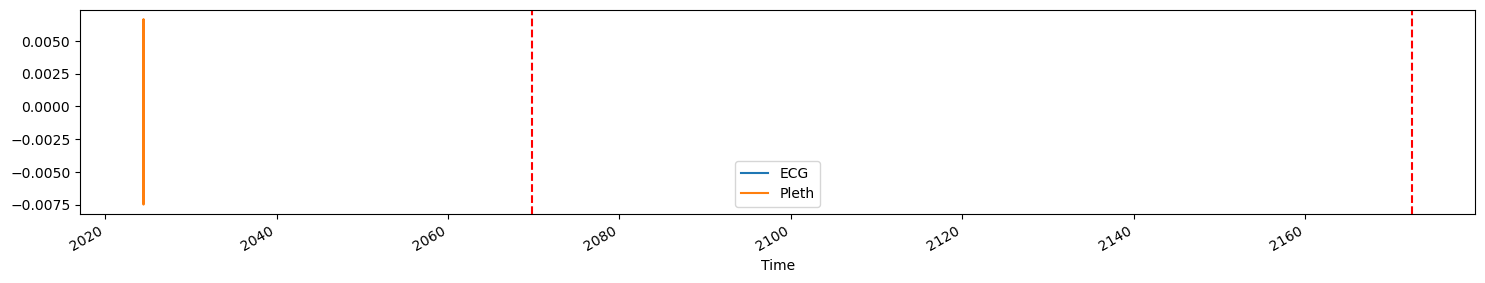

In [244]:
# Define events for specific event types (label value above threshold: 0)
# , df_subset['Limb Movement (Right)']
events3 = nk.events_find(df_subset[event_type], threshold=0, threshold_keep='above')
print(events3)
plot = nk.events_plot(events3, df_subset[['ECG', 'Pleth']])


{'onset': array([    0, 57170, 87522]), 'duration': array([36455, 16763, 35359]), 'label': array(['1', '2', '3'], dtype='<U21')}


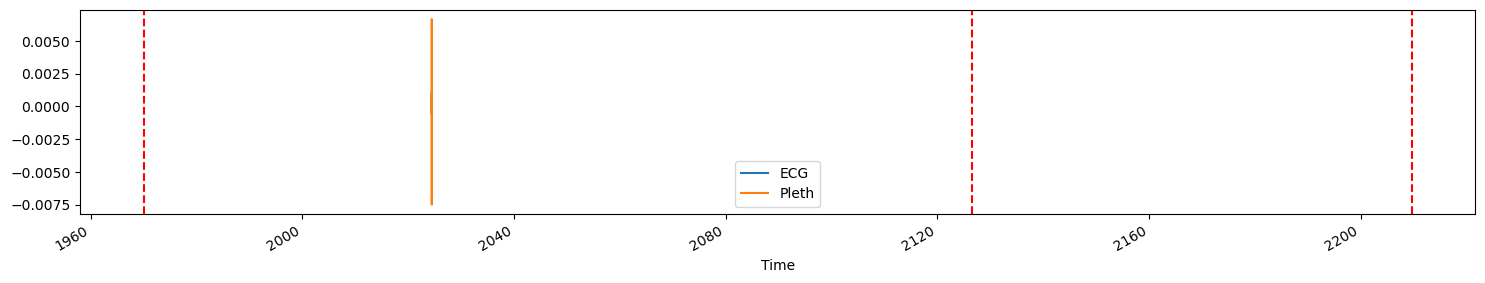

In [245]:
events4 = nk.events_find(df_subset[event_type], threshold=0, threshold_keep='below')
print(events4)
plot = nk.events_plot(events4, df_subset[['ECG', 'Pleth']])

In [246]:
# Combine the arrays
combined_onset = np.concatenate((events3['onset'], events4['onset']))
combined_duration = np.concatenate((events3['duration'], events4['duration']))

# Sort the arrays based on the combined onset values
sorted_indices = np.argsort(combined_onset)
sorted_onset = combined_onset[sorted_indices]
sorted_duration = combined_duration[sorted_indices]
sorted_label = [str(i+1) for i in range(len(sorted_onset))]


# Create the merged dictionary
merged_events = {
    'onset': sorted_onset,
    'duration': sorted_duration,
    'label': sorted_label
}

print(merged_events)


{'onset': array([    0, 36455, 57170, 73933, 87522]), 'duration': array([36455, 20715, 16763, 13589, 35359]), 'label': ['1', '2', '3', '4', '5']}


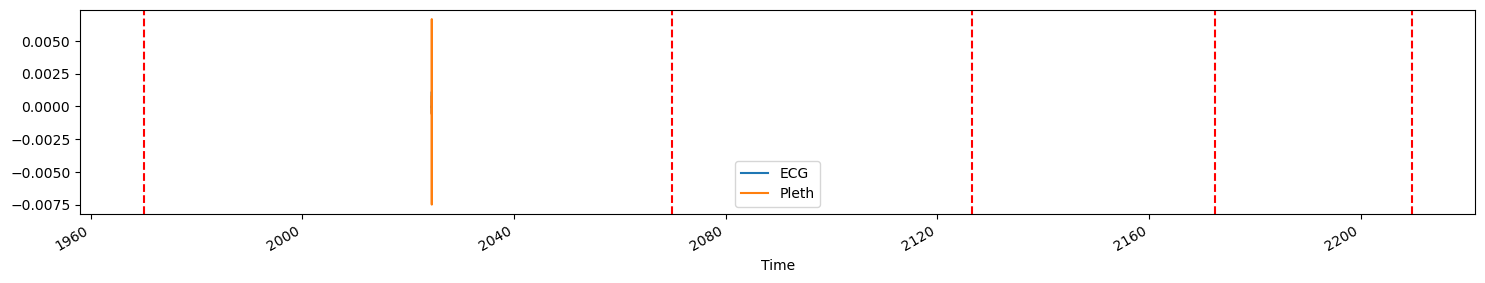

In [247]:
plot = nk.events_plot(merged_events, df_subset[['ECG', 'Pleth']])

#### Process the Signals

In [248]:
df_subset["ECG"].describe()

count    1.228810e+05
mean    -1.138511e-07
std      1.208194e-04
min     -5.425536e-04
25%     -4.198138e-05
50%     -2.313649e-05
75%      1.447700e-05
max      1.122129e-03
Name: ECG, dtype: float64

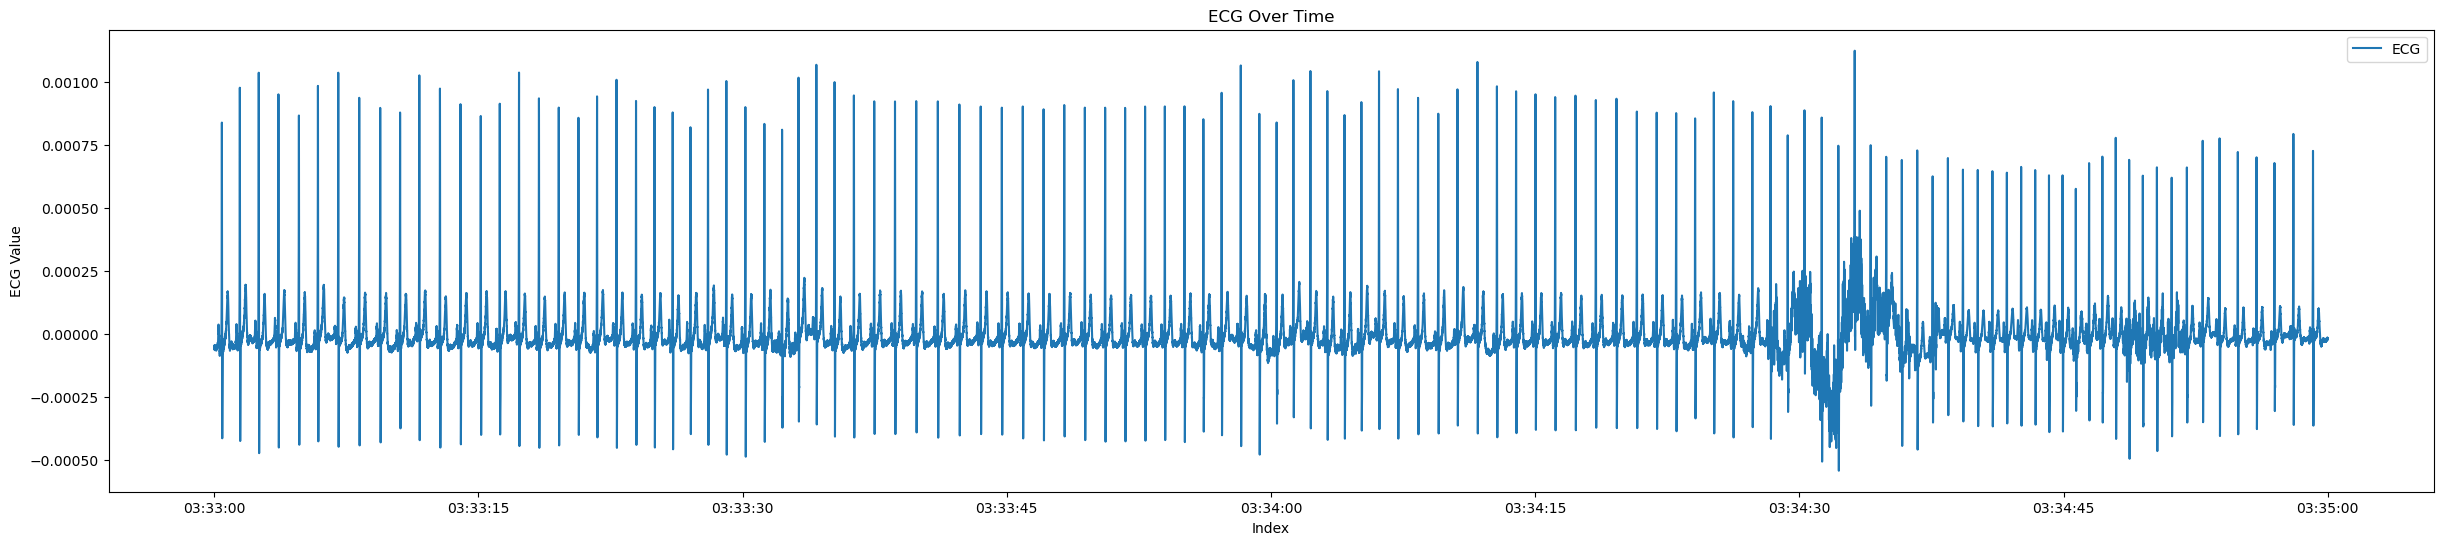

In [249]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset['ECG'], label='ECG')  # Plot the ECG column
plt.title('ECG Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('ECG Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

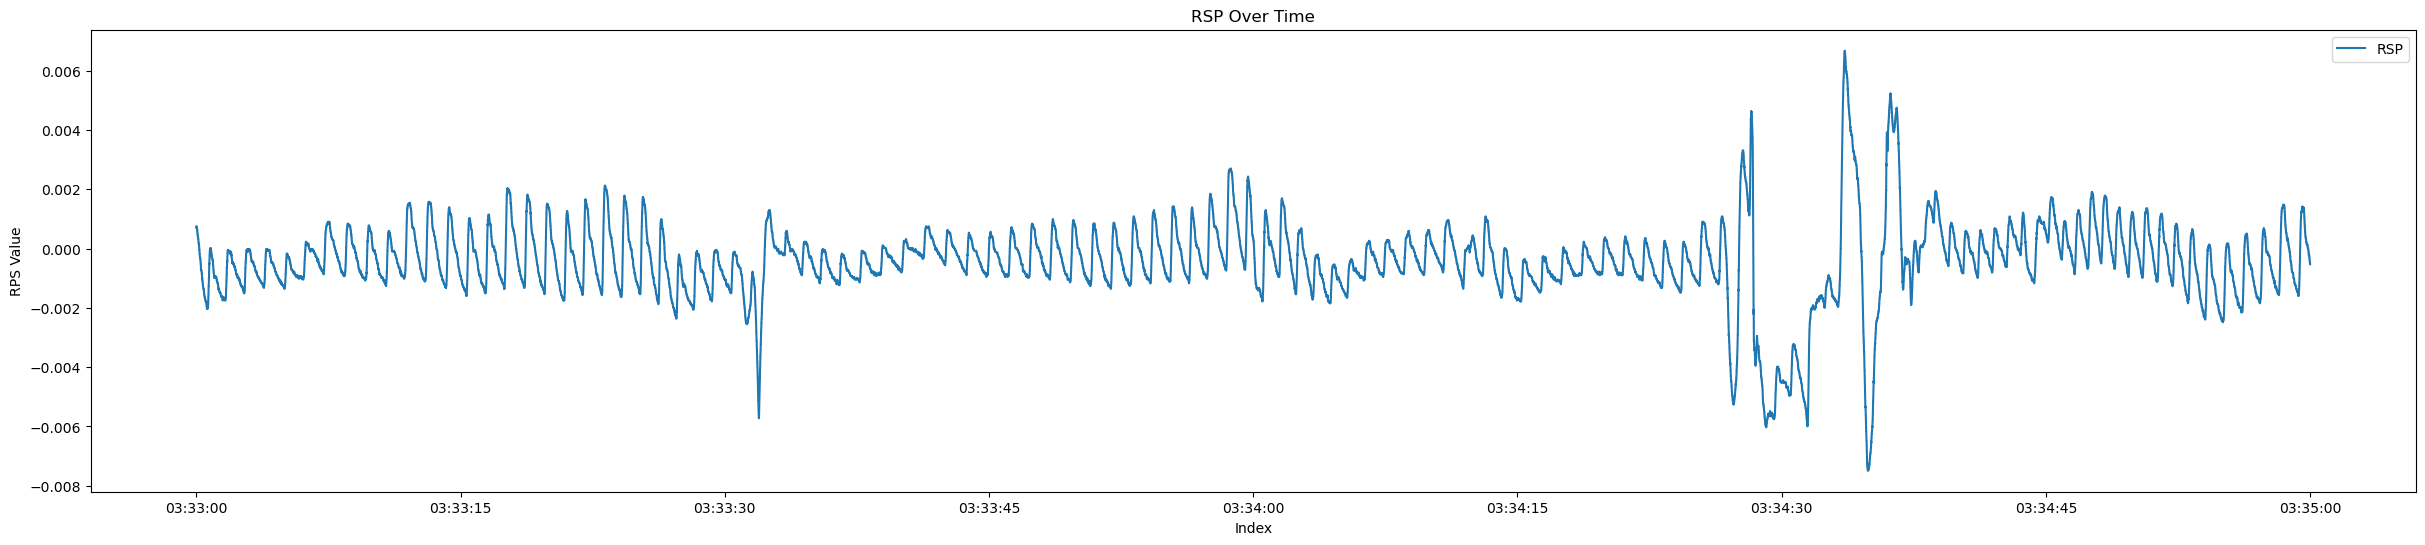

In [250]:
plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset['Pleth'], label='RSP')  # Plot the ECG column
plt.title('RSP Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('RPS Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

array([<Axes: >, <Axes: >], dtype=object)

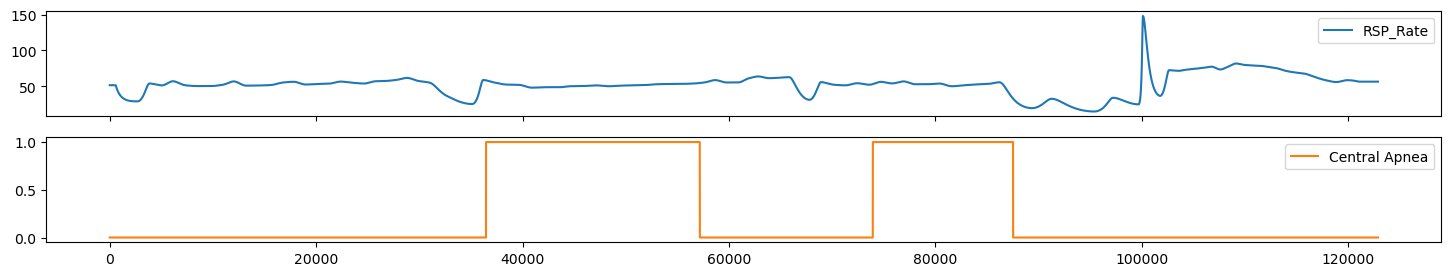

In [251]:
# Process the signal
data_clean, info = nk.bio_process(
                                  rsp=df_subset["Pleth"],
                                  keep=df_subset[event_type],  
                                  sampling_rate=1024)

# Visualize some of the channels
data_clean[["RSP_Rate", event_type]].plot(subplots=True)

#### Create Epochs

In [252]:
# Build and plot epochs
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=-30, epochs_end=30)

In [253]:
for epoch_index, epoch in epochs.items():
    for attribute, value in epoch.items():
        print(f"  {attribute}")
    print("\n")  # Adds a newline for better readability between epochs

  RSP_Raw
  RSP_Clean
  RSP_Amplitude
  RSP_Rate
  RSP_RVT
  RSP_Phase
  RSP_Phase_Completion
  RSP_Symmetry_PeakTrough
  RSP_Symmetry_RiseDecay
  RSP_Peaks
  RSP_Troughs
  Central Apnea
  Index
  Label


  RSP_Raw
  RSP_Clean
  RSP_Amplitude
  RSP_Rate
  RSP_RVT
  RSP_Phase
  RSP_Phase_Completion
  RSP_Symmetry_PeakTrough
  RSP_Symmetry_RiseDecay
  RSP_Peaks
  RSP_Troughs
  Central Apnea
  Index
  Label


  RSP_Raw
  RSP_Clean
  RSP_Amplitude
  RSP_Rate
  RSP_RVT
  RSP_Phase
  RSP_Phase_Completion
  RSP_Symmetry_PeakTrough
  RSP_Symmetry_RiseDecay
  RSP_Peaks
  RSP_Troughs
  Central Apnea
  Index
  Label


  RSP_Raw
  RSP_Clean
  RSP_Amplitude
  RSP_Rate
  RSP_RVT
  RSP_Phase
  RSP_Phase_Completion
  RSP_Symmetry_PeakTrough
  RSP_Symmetry_RiseDecay
  RSP_Peaks
  RSP_Troughs
  Central Apnea
  Index
  Label


  RSP_Raw
  RSP_Clean
  RSP_Amplitude
  RSP_Rate
  RSP_RVT
  RSP_Phase
  RSP_Phase_Completion
  RSP_Symmetry_PeakTrough
  RSP_Symmetry_RiseDecay
  RSP_Peaks
  RSP_Troughs
  Central

In [254]:
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals
    print(epoch['Label'])

-30.000000    1
-29.999023    1
-29.998047    1
-29.997070    1
-29.996094    1
             ..
 29.996094    1
 29.997070    1
 29.998047    1
 29.999023    1
 30.000000    1
Name: Label, Length: 61440, dtype: string
-30.000000    2
-29.999023    2
-29.998047    2
-29.997070    2
-29.996094    2
             ..
 29.996094    2
 29.997070    2
 29.998047    2
 29.999023    2
 30.000000    2
Name: Label, Length: 61440, dtype: string
-30.000000    3
-29.999023    3
-29.998047    3
-29.997070    3
-29.996094    3
             ..
 29.996094    3
 29.997070    3
 29.998047    3
 29.999023    3
 30.000000    3
Name: Label, Length: 61440, dtype: string
-30.000000    4
-29.999023    4
-29.998047    4
-29.997070    4
-29.996094    4
             ..
 29.996094    4
 29.997070    4
 29.998047    4
 29.999023    4
 30.000000    4
Name: Label, Length: 61440, dtype: string
-30.000000    5
-29.999023    5
-29.998047    5
-29.997070    5
-29.996094    5
             ..
 29.996094    5
 29.997070    5


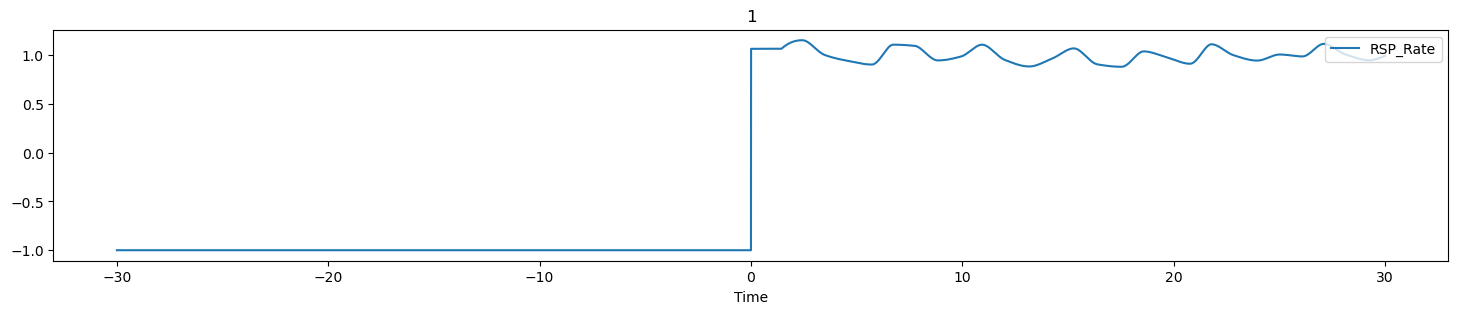

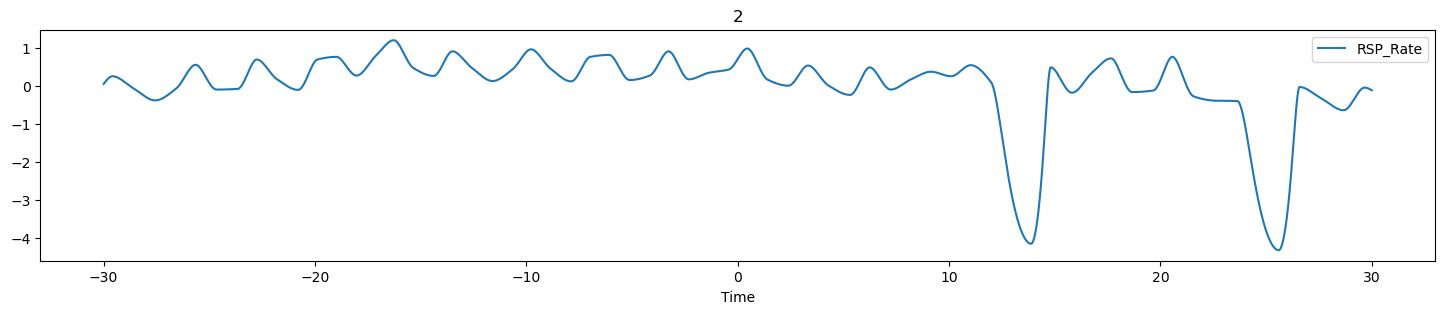

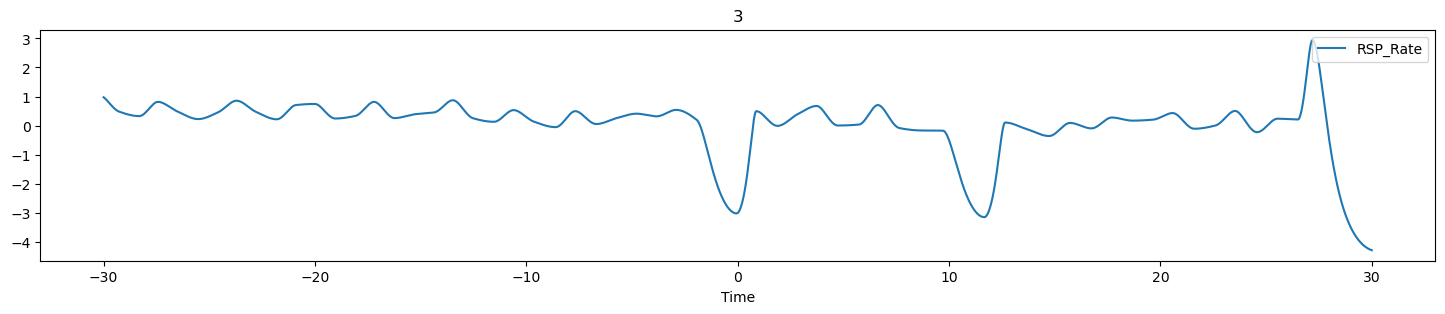

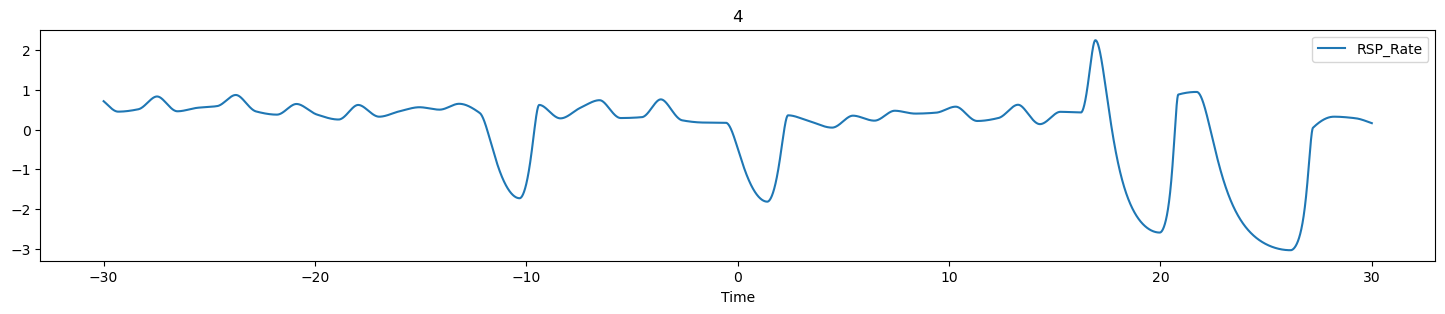

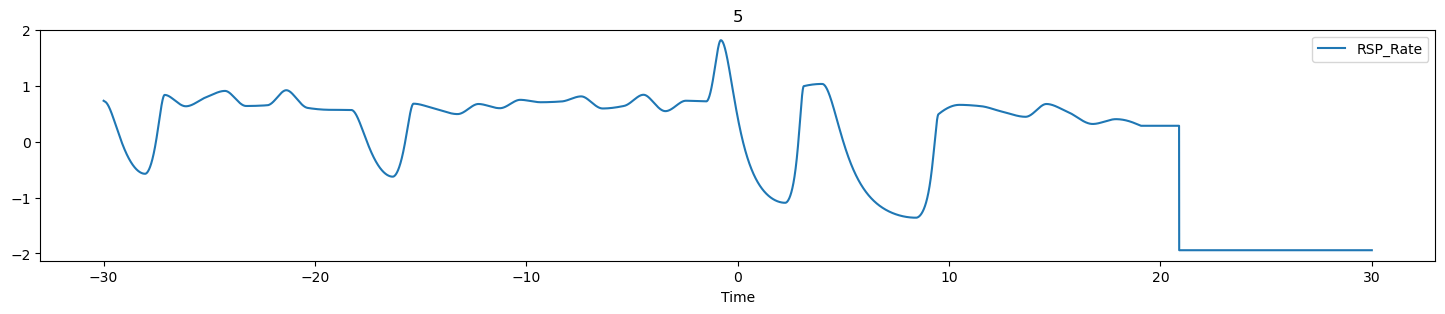

In [ ]:
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals, "Stage Code"
    nk.signal_plot(epoch[['RSP_Rate']], 
                   title=epoch['Label'].values[0],  # Extract condition name
                   standardize=True)  

#### Interval Analysis

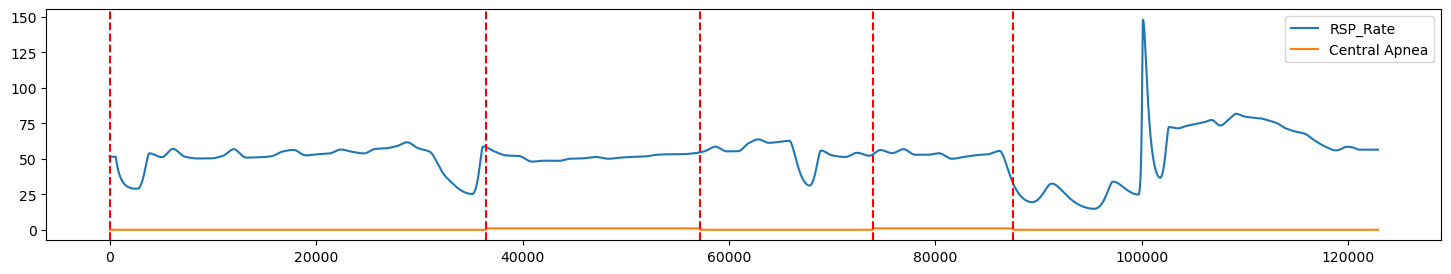

In [255]:
plot = nk.events_plot(merged_events,data_clean[["RSP_Rate", event_type]])

In [256]:
print(merged_events)
epochs = nk.epochs_create(data_clean, merged_events, sampling_rate=1024, epochs_start=0, epochs_end='from_events')

{'onset': array([    0, 36455, 57170, 73933, 87522]), 'duration': array([36455, 20715, 16763, 13589, 35359]), 'label': ['1', '2', '3', '4', '5']}


In [257]:
nk.rsp_intervalrelated(epochs)

,Label,RSP_Rate_Mean,RRV_RMSSD,RRV_MeanBB,RRV_SDBB,RRV_SDSD,RRV_CVBB,RRV_CVSD,RRV_MedianBB,RRV_MadBB,...,RAV_Mean,RAV_SD,RAV_RMSSD,RAV_CVSD,RSP_RVT,RSP_Symmetry_PeakTrough,RSP_Symmetry_RiseDecay,RSP_Phase_Duration_Inspiration,RSP_Phase_Duration_Expiration,RSP_Phase_Duration_Ratio
1,1,50.079344,372.085484,1227.379310,317.860528,376.883269,0.258975,0.303154,1141.0,88.9560,...,0.002335,0.001043,0.001383,0.592008,0.000173,0.554737,0.290802,0.000345,0.000852,0.404585
2,2,51.475860,31.101983,1201.625000,42.136089,32.117789,0.035066,0.025883,1196.0,45.2193,...,0.001544,0.000543,0.000116,0.074866,0.000049,0.582840,0.262589,0.000306,0.000861,0.355052
3,3,54.390859,369.894892,1140.428571,252.279062,384.860248,0.221214,0.324347,1105.0,121.5732,...,0.002021,0.000727,0.000396,0.196008,0.000232,0.543066,0.334831,0.000378,0.000734,0.514587
4,4,52.674536,49.723681,1152.900000,41.589128,52.604922,0.036073,0.043129,1157.5,28.9107,...,0.001364,0.000256,0.000211,0.154934,0.000116,0.591566,0.312588,0.000311,0.000782,0.397694
5,5,53.480095,808.242698,1129.285714,732.603923,823.086932,0.648732,0.715711,853.5,109.7124,...,0.002804,0.002526,0.002658,0.948070,0.001004,0.514272,0.437421,0.000483,0.000613,0.787799


In [259]:
pnea_df

,Name,Actual Start (sec),Duration,Start,End,Input
388,Central Apnea,19862.6,18.23,2024-06-21 03:33:36.600,2024-06-21 03:33:54.830,Airflow
391,Central Apnea,19899.2,11.27,2024-06-21 03:34:13.200,2024-06-21 03:34:24.470,Airflow


                                 ECG     Pleth  Mixed Apnea  \
Time                                                          
2024-06-21 03:32:00.000000 -0.000039  0.000443            0   
2024-06-21 03:32:00.000977 -0.000042  0.000443            0   
2024-06-21 03:32:00.001953 -0.000044  0.000443            0   
2024-06-21 03:32:00.002930 -0.000044  0.000443            0   
2024-06-21 03:32:00.003906 -0.000041  0.000412            0   

                            Limb Movement (Left)  Limb Movement (Right)  \
Time                                                                      
2024-06-21 03:32:00.000000                     0                      0   
2024-06-21 03:32:00.000977                     0                      0   
2024-06-21 03:32:00.001953                     0                      0   
2024-06-21 03:32:00.002930                     0                      0   
2024-06-21 03:32:00.003906                     0                      0   

                            SpO2

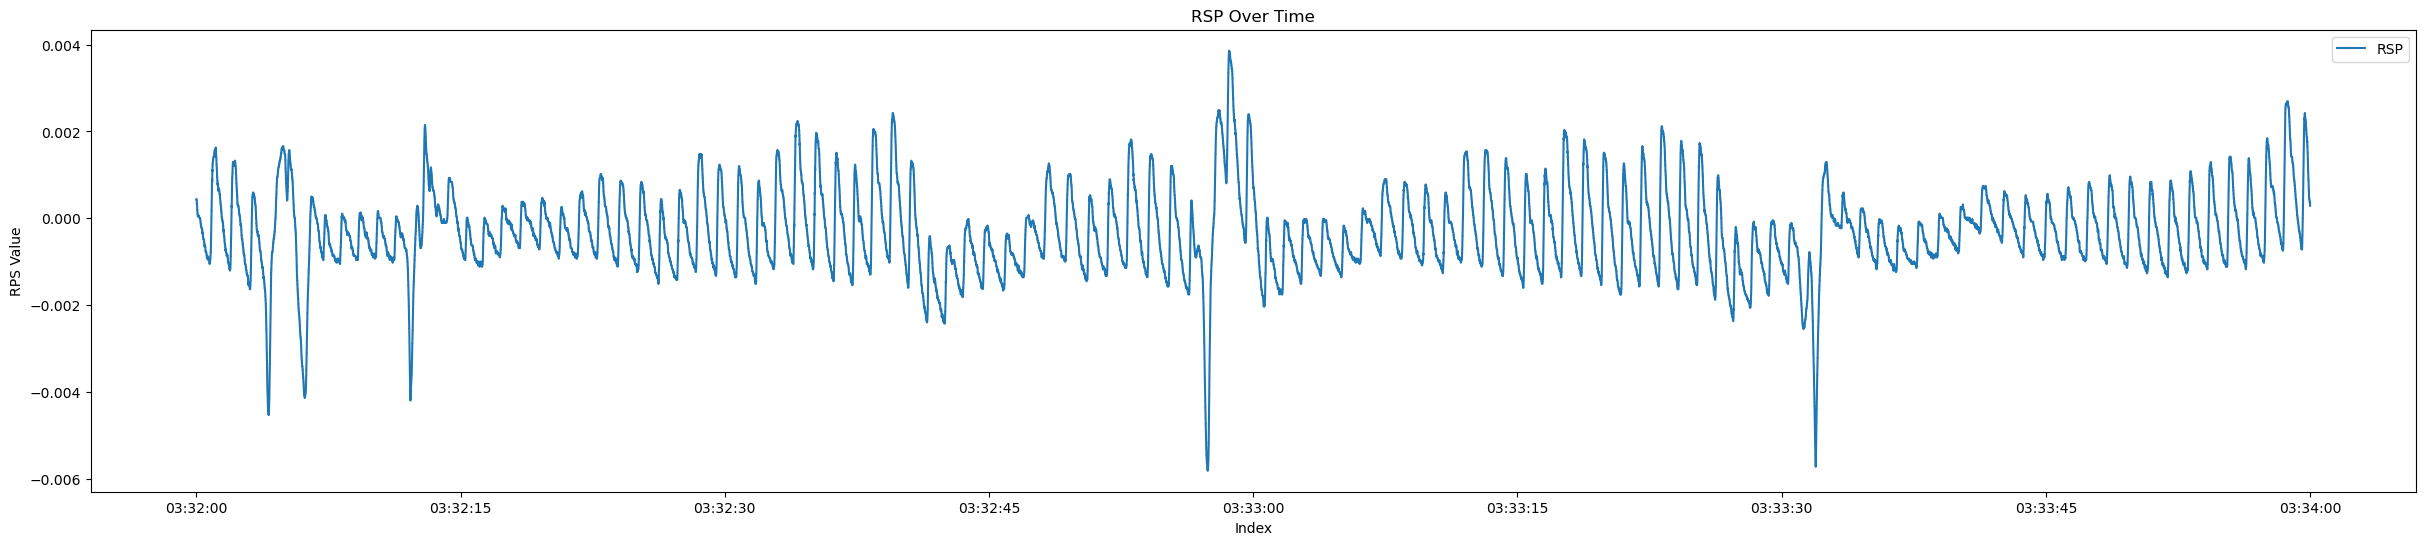

In [261]:
# 2024-06-21 03:33:36.600	2024-06-21 03:33:54.830
start_datetime = datetime(2024, 6, 21, 3, 32, 00)
end_datetime = datetime(2024, 6, 21, 3, 34, 00) 

start_time = start_datetime
end_time = end_datetime

filtered_df2 = df.loc[start_time:end_time]
# Make a df subset with all the columns except: 
# 'ECG', 'Pleth', 'Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 
# 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)'
columns_to_drop = ['Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 'REM Sleep', 'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)']
df_subset2 = filtered_df2.drop(columns=columns_to_drop)
print(df_subset2.head())

plt.figure(figsize=(30, 6))  # Set figure size for better readability
plt.plot(df_subset2['Pleth'], label='RSP')  # Plot the ECG column
plt.title('RSP Over Time')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('RPS Value')  # Y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot